In [585]:
import os
import pandas as pd
import openpyxl
import numpy as np
import re
import matplotlib.pyplot as plt

# Preprocess DEVICES.XLSX

Before importing the xlsx files, open them and delete the first rows manually

In [586]:
device_df = pd.read_excel("challenge/challenge/data/DEVICES.xlsx")
device_df.columns, device_df.shape

(Index(['ID', 'TYPE', 'AREA', 'FUNCTION', 'MANUFACTURER', 'INSTALL DATE',
        'PHASES', 'POWER (MVA)', 'VOLTAGE REGULATION', 'NOMINAL VOLTAGE (KV)'],
       dtype='object'),
 (651, 10))

In [588]:
device_df.describe()

,ID,TYPE,AREA,FUNCTION,MANUFACTURER,INSTALL DATE,PHASES,POWER (MVA),VOLTAGE REGULATION,NOMINAL VOLTAGE (KV)
count,651,651,651,651,648,554,629,633,623,631
unique,651,4,7,25,28,427,2,30,2,10
top,e230c8f5b9c635e054be4463878b1f37,Power Transformer,CE,T1,MANUFACTURER-23,29.03.1999,THREE,"25,00",NO,"138,00"
freq,1,373,123,261,225,7,621,193,323,366


## Check nan values

### 1. Count the number of nan values in each columns

In [589]:
# Check the count of NA values in each column
na_counts = device_df.isna().sum()  

print(na_counts)

ID                       0
TYPE                     0
AREA                     0
FUNCTION                 0
MANUFACTURER             3
INSTALL DATE            97
PHASES                  22
POWER (MVA)             18
VOLTAGE REGULATION      28
NOMINAL VOLTAGE (KV)    20
dtype: int64


+ INSTALL DATE is the key feature to detect Failure
+ Inappropriate imputing for this feature might lead to wrong detection for Failure <br><br>
**Therefore, Remove records that INSTALL DATE are NaN**

In [590]:
# Remove rows with NaN values in 'INSTALL DATE' column
device_df = device_df.dropna(subset=['INSTALL DATE'])
print("Already removed NaN records of INSTALL DATE")

Already removed NaN records of INSTALL DATE


### 2. Count the number of nan values in each row

In [591]:
# Count the number of nan values in each row
nan_counts = device_df.isna().sum(axis=1)
nan_count_occurrences = nan_counts.value_counts()
# Convert the Series to a DataFrame
nan_count_df = pd.DataFrame(nan_count_occurrences)

# Add a header to the DataFrame
nan_count_df.columns = ['Nunber of NaN values in a row']

print(nan_count_df)

   Nunber of NaN values in a row
0                            537
1                             13
2                              2
4                              2


### 3. Remove records that have more than 2 nan values

In [592]:
# Remove reocords have more than 2 nan values
device_df = device_df.dropna(thresh=device_df.shape[1] - 2)
device_df = device_df.reset_index(drop=True)

nan_counts = device_df.isna().sum(axis=1)
# Count the number of NaN values in each row
nan_count_occurrences = nan_counts.value_counts()

# Convert the Series to a DataFrame
nan_count_df = pd.DataFrame(nan_count_occurrences)

# Add a header to the DataFrame
nan_count_df.columns = ['Row Count with NaN']

print("After removing")
print(nan_count_df)

After removing
   Row Count with NaN
0                 537
1                  13
2                   2


In [593]:
device_df.describe()

,ID,TYPE,AREA,FUNCTION,MANUFACTURER,INSTALL DATE,PHASES,POWER (MVA),VOLTAGE REGULATION,NOMINAL VOLTAGE (KV)
count,552,552,552,552,552,552,548,551,543,549
unique,552,4,7,20,27,425,2,30,2,9
top,e230c8f5b9c635e054be4463878b1f37,Power Transformer,TA,T1,MANUFACTURER-23,29.03.1999,THREE,"25,00",NO,"138,00"
freq,1,329,102,225,186,7,544,162,281,314


## Explore & Preprocess Data 

### 1. MANUFACTURER

In [594]:
set(device_df["MANUFACTURER"].to_list())

{'MAN-1',
 'MANFCT-5',
 'MANUF-11',
 'MANUFAC-013',
 'MANUFAC01',
 'MANUFACTRUER-05',
 'MANUFACTURE-19',
 'MANUFACTURER-001',
 'MANUFACTURER-01',
 'MANUFACTURER-01b',
 'MANUFACTURER-02',
 'MANUFACTURER-03',
 'MANUFACTURER-05',
 'MANUFACTURER-07',
 'MANUFACTURER-08',
 'MANUFACTURER-09',
 'MANUFACTURER-10',
 'MANUFACTURER-12',
 'MANUFACTURER-14',
 'MANUFACTURER-22',
 'MANUFACTURER-23',
 'MANUFACTURER-24',
 'MANUFACTURER-25',
 'MANUFACTURER-26',
 'MANUFACTURER-27',
 'MANUFACTURER-UNKNWN',
 'MNAUFACTURER-4'}

The value of MANUFACTURER should be MANUFACTURER-xx

In [595]:
for i in range(0, len(device_df)):
    
    if device_df["MANUFACTURER"].iloc[i] in ["MAN-1", "MANUFACTURER-001", "MANUFACTURER-01b", "MANUFAC01", "MANUFACTURER-01"]:
        device_df.loc[i, "MANUFACTURER"] = "MANUFACTURER-01"
    elif device_df["MANUFACTURER"].iloc[i] in ["MANFCT-5", "MANUFACTRUER-05"]:
        device_df.loc[i, "MANUFACTURER"] = "MANUFACTURER-05"
    elif device_df["MANUFACTURER"].iloc[i] in ["MANUF-11"]:
        device_df.loc[i, "MANUFACTURER"] = "MANUFACTURER-11"
    elif device_df["MANUFACTURER"].iloc[i] in ["MANUFAC-013"]:
        device_df.loc[i, "MANUFACTURER"] = "MANUFACTURER-13"
    elif device_df["MANUFACTURER"].iloc[i] in ["MNAUFACTURER-4"]:
        device_df.loc[i, "MANUFACTURER"] = "MANUFACTURER-04"
    elif device_df["MANUFACTURER"].iloc[i] in ["MANUFACTURE-19"]:
        device_df.loc[i, "MANUFACTURER"] = "MANUFACTURER-19"


In [596]:
(set(device_df["MANUFACTURER"].to_list()))

{'MANUFACTURER-01',
 'MANUFACTURER-02',
 'MANUFACTURER-03',
 'MANUFACTURER-04',
 'MANUFACTURER-05',
 'MANUFACTURER-07',
 'MANUFACTURER-08',
 'MANUFACTURER-09',
 'MANUFACTURER-10',
 'MANUFACTURER-11',
 'MANUFACTURER-12',
 'MANUFACTURER-13',
 'MANUFACTURER-14',
 'MANUFACTURER-19',
 'MANUFACTURER-22',
 'MANUFACTURER-23',
 'MANUFACTURER-24',
 'MANUFACTURER-25',
 'MANUFACTURER-26',
 'MANUFACTURER-27',
 'MANUFACTURER-UNKNWN'}

In [597]:
manufacturer_count = {}
for i in device_df["MANUFACTURER"].to_list():
    manufacturer_count[i] = device_df["MANUFACTURER"].to_list().count(i)
manufacturer_count = dict(sorted(manufacturer_count.items(), key=lambda item: item[1], reverse=True))
manufacturer_count

{'MANUFACTURER-23': 186,
 'MANUFACTURER-01': 113,
 'MANUFACTURER-UNKNWN': 67,
 'MANUFACTURER-22': 53,
 'MANUFACTURER-08': 26,
 'MANUFACTURER-02': 16,
 'MANUFACTURER-19': 15,
 'MANUFACTURER-09': 14,
 'MANUFACTURER-05': 13,
 'MANUFACTURER-24': 12,
 'MANUFACTURER-27': 7,
 'MANUFACTURER-04': 7,
 'MANUFACTURER-26': 5,
 'MANUFACTURER-07': 5,
 'MANUFACTURER-13': 4,
 'MANUFACTURER-11': 3,
 'MANUFACTURER-14': 2,
 'MANUFACTURER-12': 1,
 'MANUFACTURER-10': 1,
 'MANUFACTURER-25': 1,
 'MANUFACTURER-03': 1}

### INSTALL DATE

In [598]:
set(device_df["INSTALL DATE"].to_list())

{'01.01.1971',
 '01.01.1981',
 '01.01.1983',
 '01.01.1985',
 '01.01.1987',
 '01.01.1991',
 '01.01.1992',
 '01.01.1993',
 '01.01.1998',
 '01.01.1999',
 '01.01.9999',
 '01.02.1974',
 '01.02.1978',
 '01.02.1979',
 '01.02.1982',
 '01.02.1990',
 '01.02.1993',
 '01.02.1995',
 '01.02.2012',
 '01.03.1983',
 '01.03.1984',
 '01.03.1988',
 '01.03.1993',
 '01.03.1995',
 '01.04.1970',
 '01.04.1980',
 '01.04.1986',
 '01.04.1988',
 '01.04.1991',
 '01.04.1996',
 '01.04.1998',
 '01.04.1999',
 '01.04.2002',
 '01.04.2012',
 '01.04.2013',
 '01.05.1987',
 '01.05.1989',
 '01.05.1991',
 '01.05.1993',
 '01.05.1996',
 '01.05.2003',
 '01.06.1985',
 '01.06.1987',
 '01.06.1989',
 '01.06.1991',
 '01.06.1992',
 '01.06.1993',
 '01.06.1995',
 '01.06.1996',
 '01.06.1997',
 '01.06.1998',
 '01.06.2012',
 '01.07.1977',
 '01.07.1980',
 '01.07.1981',
 '01.07.1989',
 '01.07.1991',
 '01.07.1992',
 '01.07.1993',
 '01.07.1996',
 '01.07.2012',
 '01.08.1970',
 '01.08.1978',
 '01.08.1985',
 '01.08.1987',
 '01.08.1988',
 '01.08.19

In [599]:
# Filter the DataFrame to exclude rows with NaN values in 'INSTALL DATE' column
not_na_mask = device_df['INSTALL DATE'].notna()
filtered_dates = device_df.loc[not_na_mask, 'INSTALL DATE']

# Get the type of each record
types_of_dates = filtered_dates.apply(type)

types_of_dates.to_list()
count_type = {}
for i in types_of_dates.to_list():
    count_type[i] = types_of_dates.to_list().count(i)
print("Count of each type",count_type)


Count of each type {<class 'str'>: 547, <class 'int'>: 2, <class 'float'>: 3}


The majority type of the records are STR, minority is INT and FLOAT. <br>
Solutions, convert all of them to STR

In [600]:
device_df['INSTALL DATE'] = device_df['INSTALL DATE'].apply(lambda x: str(x) if not pd.isna(x) else x)

In [601]:
# Create a regular expression pattern for 'xx.xx.xxxx'
pattern_1 = r'\d{2}[./]\d{2}[./]\d{4}'

# Create a regular expression pattern for 'xx-xx-xxxx'
pattern_2 = r'\d{2}[-/]\d{2}[-/]\d{4}'

# Initialize count for each pattern 
count_pattern_1 = 0
count_pattern_2 = 0
count_other_patterns = 0

# Loop through the 'INSTALL DATE' column and count occurrences of the pattern
for date_str in device_df['INSTALL DATE'].astype(str):
    if pd.notna(date_str) and re.match(pattern_1, date_str):
        count_pattern_1 += 1
    elif pd.notna(date_str) and re.match(pattern_2, date_str):
        count_pattern_2 += 1
    else:
        count_other_patterns += 1

print("Count for 'xx.xx.xxxx' pattern:", count_pattern_1)
print("Count for 'xx-xx-xxxx' pattern:", count_pattern_2)
print("Count for other patterns:", count_other_patterns)

Count for 'xx.xx.xxxx' pattern: 521
Count for 'xx-xx-xxxx' pattern: 14
Count for other patterns: 17


The pattern xx.xx.xxxx of INSTALL DATE has the highest count.<br>
Thus, convert all INSTALL DATE to this pattern.

In [602]:
# Check for non-null values (not NaN) in the 'INSTALL DATE' column
mask_notna = pd.notna(device_df['INSTALL DATE'])

# Use str.replace() to remove characters .,/\- from non-null values
device_df.loc[mask_notna, 'INSTALL DATE'] = device_df.loc[mask_notna, 'INSTALL DATE'].str.replace(r'[.,/\-]', '', regex=True)

# Convert "ddmmyyyy" to "xx.xx.xxxx" format
mask_ddmmyyyy = device_df['INSTALL DATE'].str.contains(r'\d{2}\d{2}\d{4}', na=False)
device_df.loc[mask_ddmmyyyy, 'INSTALL DATE'] = device_df.loc[mask_ddmmyyyy, 'INSTALL DATE'].str.replace(r'(\d{2})(\d{2})(\d{4})', r'\1.\2.\3', regex=True)


Below are abnormal format 

In [603]:
abnormal_format = device_df.loc[pd.notna(device_df['INSTALL DATE']) & (device_df['INSTALL DATE'].str.len() != 10), 'INSTALL DATE']
display(abnormal_format)
print("Total number of abnormal format:", len(abnormal_format))


85     0X0X2012
140       71999
197          ND
252      160805
253      062000
298       40988
406      121994
439       61995
506      030705
517      220206
518      300806
519      151206
520      151206
522      090107
534    0X0X2012
535    0X0X2012
Name: INSTALL DATE, dtype: object

Total number of abnormal format: 16


+ Remove row that INSTALL DATE is "ND"
+ Remove rows that have only 5 digits (71999, 40988, 61995)
+ For 0X0X2012, assume 0X0X = 0101
+ For 062000, convert to 01.06.2000
+ For 121994, convert to 01.12.1994
+ For 160805, 030705, 220206, 300806, 151206, 090107, convert them to dd.mm.20yy


In [604]:
print("The number of rows that INSTALL DATE contains 'ND':", len(device_df[device_df['INSTALL DATE'] == "ND"]))

# Remove row that INSTALL DATE is "ND"
device_df = device_df.drop(device_df[device_df['INSTALL DATE'] == "ND"].index)

print("-------------------")
print("Already removed rows that INSTALL DATE is 'ND'")

The number of rows that INSTALL DATE contains 'ND': 1
-------------------
Already removed rows that INSTALL DATE is 'ND'


In [605]:
# Find rows in the 'INSTALL DATE' column that contain 5-digit strings
mask_5_digits = device_df['INSTALL DATE'].str.contains(r'\b\d{5}\b', na=False)

# Filter the DataFrame to get rows with 5-digit strings in the 'INSTALL DATE' column
rows_with_5_digits = device_df[mask_5_digits]

device_df = device_df[~mask_5_digits]
print("The number of rows that INSTALL DATE contains only 5 digits:", len(rows_with_5_digits))
print("-------------------")
print(f"Already removed {len(rows_with_5_digits)} rows that INSTALL DATE has only 5 digits")

The number of rows that INSTALL DATE contains only 5 digits: 3
-------------------
Already removed 3 rows that INSTALL DATE has only 5 digits


In [606]:
# Convert "0X.0X" to "01.01"
mask_0X0X = device_df['INSTALL DATE'] == '0X0X2012'
device_df.loc[mask_0X0X, 'INSTALL DATE'] = "01.01.2012"

print("Already converted 0X.0X to 01.01")

Already converted 0X.0X to 01.01


In [607]:
# Convert "062000" to "01.06.2000"
mask_062000 = device_df['INSTALL DATE'] == '062000'
device_df.loc[mask_062000, 'INSTALL DATE'] = "01.06.2000"

print("Already converted 062000 to 01.06.2000")

Already converted 062000 to 01.06.2000


In [608]:
# Convert "121994" to "01.12.1994"
mask_062000 = device_df['INSTALL DATE'] == '121994'
device_df.loc[mask_062000, 'INSTALL DATE'] = "01.12.1994"

print("Already converted 121994 to 01.12.1994")

Already converted 121994 to 01.12.1994


In [609]:
# Convert "ddmmyy" to "xx.xx.20xx"
mask_ddmmyy = device_df['INSTALL DATE'].str.contains(r'\d{2}\d{2}\d{2}', na=False)
device_df.loc[mask_ddmmyy, 'INSTALL DATE'] = device_df.loc[mask_ddmmyy, 'INSTALL DATE'].str.replace(r'(\d{2})(\d{2})(\d{2})', r'\1.\2.20\3', regex=True)

print("Already converted 'ddmmyy' to 'dd.mm.20yy'")

Already converted 'ddmmyy' to 'dd.mm.20yy'


Explore the mean, std, min and max INSTALL DATE

In [610]:
# Remove NaN values first (if any)
install_dates = device_df['INSTALL DATE'].dropna()

# Split the date strings and extract the year part
years_list = [int(date.split('.')[-1]) for date in install_dates]
sorted_years = sorted(list(set(years_list)))
second_lowest = sorted_years[1]
second_highest = sorted_years[-2]
third_lowest = sorted_years[2]
third_highest = sorted_years[-3]


print("Highest Year:", max(years_list))
print("Lowest Year:", min(years_list))
print("")

print("Second Highest Year:", second_highest)
print("Second Lowest Year:", second_lowest)
print("")

print("Third Highest Year:", third_highest)
print("Third Lowest Year:", third_lowest)
print("")

mean_years = np.mean(years_list)
std_years = np.std(years_list)
print("Mean Year:", mean_years)
print("STD:", std_years)


Highest Year: 9999
Lowest Year: 1946

Second Highest Year: 2013
Second Lowest Year: 1955

Third Highest Year: 2012
Third Lowest Year: 1967

Mean Year: 2024.7244525547446
STD: 482.7557931557427


As can be seen, the highest year (9999) is an abnormal value. Thats the reason causing the mean and std higher than normal. <br>


In [611]:
count_9999 = years_list.count(9999)
print("The number of records that has year of 9999:", count_9999)

The number of records that has year of 9999: 2


Since the number of records contain the year of 9999 is only 2, <br>
Solution is to remove the records that INSTALL DATE is xx.xx.9999

In [612]:
# Check if 'INSTALL DATE' column contains the pattern 'xx.xx.9999' or is NaN
mask_not_9999_or_nan = ~device_df['INSTALL DATE'].str.contains(r'\d{2}\.\d{2}\.9999', na=False)

# Keep 'INSTALL DATE' does not contain 'xx.xx.9999' or is not NaN
device_df = device_df[mask_not_9999_or_nan]

# Remove NaN values first 
install_dates = device_df['INSTALL DATE'].dropna()

# Split the date strings and extract the year part
years_list = [int(date.split('.')[-1]) for date in install_dates]

mean_year = np.mean(years_list)
std_year = np.std(years_list)

print("Mean, Std, Max and Min Year after removing the year of 9999")
print("-----------------------")
print("Mean Year:", mean_year)
print("Std Year:", std_year)
print("Max Year:", max(years_list))
print("Min Year:", min(years_list))

Mean, Std, Max and Min Year after removing the year of 9999
-----------------------
Mean Year: 1995.514652014652
Std Year: 11.252544098488572
Max Year: 2013
Min Year: 1946


### PHASES

In [613]:
set(device_df["PHASES"].to_list())

{'SINGLE', 'THREE', nan}

Convert 'SINGLE' to 1 and "THREE" to 3

In [614]:
# Create a mask for rows containing 'SINGLE' in the 'PHASES' column
mask_single = device_df['PHASES'] == 'SINGLE'

# Create a mask for rows containing 'THREE' in the 'PHASES' column
mask_three = device_df['PHASES'] == 'THREE'

# Replace 'SINGLE' with 1 for the selected rows
device_df.loc[mask_single, 'PHASES'] = 1

# Replace 'THREE' with 3 for the selected rows
device_df.loc[mask_three, 'PHASES'] = 3

print("Already converted 'SINGLE' to 1 and 'THREE' to 3")

Already converted 'SINGLE' to 1 and 'THREE' to 3


### POWER (MVA)

In [615]:
set(device_df["POWER (MVA)"].to_list())

{'0,22',
 '1,00',
 '1,25',
 '1,50',
 '10,00',
 '12,50',
 '13,30',
 '14,00',
 '15,00',
 '2,00',
 '2,25',
 '2,50',
 '25,00',
 '3,30',
 '30,00',
 '33,00',
 '33,20',
 '33,30',
 '35,00',
 '4,20',
 '5,00',
 '5.000,00',
 '6,25',
 '6,60',
 '7,00',
 '7,50',
 '7,60',
 '7.500,00',
 '9,00',
 '9,37',
 nan}

As can be seen, '5.000,00' and '7.500,00' are abnormal values

In [616]:
count_abnormal_1 =  len(device_df[device_df['POWER (MVA)'] == "5.000,00"])
count_abnormal_2 =  len(device_df[device_df['POWER (MVA)'] == "7.500,00"])
print("Total of abnormal values for POWER (MVA):", count_abnormal_1 + count_abnormal_2)

Total of abnormal values for POWER (MVA): 2


Remove the rows that contains the two abnormal values for POWER (MVA)

In [617]:
device_df = device_df.drop(device_df[device_df['POWER (MVA)'] == "5.000,00"].index)
device_df = device_df.drop(device_df[device_df['POWER (MVA)'] == "7.500,00"].index)
print("Already removed!")

Already removed!


Change the separator of decimal values from "," to "."

In [618]:
# Check for non-null values (not NaN) in the 'POWER (MVA)' column
mask_notna = pd.notna(device_df['POWER (MVA)'])

# Use str.replace() to convert "," to "."
device_df.loc[mask_notna, 'POWER (MVA)'] = device_df.loc[mask_notna, 'POWER (MVA)'].str.replace(r'[,]', '.', regex=True).astype(float)

print("Already changed the separator")

Already changed the separator


### VOLTAGE REGULATION

In [619]:
set(device_df["VOLTAGE REGULATION"].to_list())

{'NO', 'YES', nan}

Convert "YES" to 1 and "NO" to 0

In [620]:
# Create a mask for rows containing 'YES' in the 'VOLTAGE REGULATION' column
mask_yes= device_df['VOLTAGE REGULATION'] == 'YES'

# Create a mask for rows containing 'NO' in the 'VOLTAGE REGULATION' column
mask_no = device_df['VOLTAGE REGULATION'] == 'NO'

# Replace 'YES' with 1 for the selected rows
device_df.loc[mask_yes, 'VOLTAGE REGULATION'] = 1

# Replace 'NO' with 0 for the selected rows
device_df.loc[mask_no, 'VOLTAGE REGULATION'] = 0

print("Already converted 'YES' to 1 and 'NO' to 0")

Already converted 'YES' to 1 and 'NO' to 0


### NOMINAL VOLTAGE (KV)

In [621]:
set(device_df["NOMINAL VOLTAGE (KV)"].to_list())

{'13,80',
 '138,00',
 '144,90',
 '145,00',
 '161,00',
 '22,00',
 '34,50',
 '69,00',
 '72,50',
 nan}

Change the separator of decimal values from "," to "."

In [622]:
# Check for non-null values (not NaN) in the 'NOMINAL VOLTAGE (KV)' column
mask_notna = pd.notna(device_df['NOMINAL VOLTAGE (KV)'])

# Use str.replace() to convert "," to "."
device_df.loc[mask_notna, 'NOMINAL VOLTAGE (KV)'] = device_df.loc[mask_notna, 'NOMINAL VOLTAGE (KV)'].str.replace(r'[,]', '.', regex=True).astype(float)

print("Already changed the separator")

Already changed the separator


### Group data into different MANUFACTURER

Assumption: Equipments have same function from the same MANUFACTURER have common in features

In [623]:
set(device_df["MANUFACTURER"].to_list())

{'MANUFACTURER-01',
 'MANUFACTURER-02',
 'MANUFACTURER-03',
 'MANUFACTURER-04',
 'MANUFACTURER-05',
 'MANUFACTURER-07',
 'MANUFACTURER-08',
 'MANUFACTURER-09',
 'MANUFACTURER-10',
 'MANUFACTURER-11',
 'MANUFACTURER-12',
 'MANUFACTURER-13',
 'MANUFACTURER-14',
 'MANUFACTURER-19',
 'MANUFACTURER-22',
 'MANUFACTURER-23',
 'MANUFACTURER-24',
 'MANUFACTURER-25',
 'MANUFACTURER-26',
 'MANUFACTURER-27',
 'MANUFACTURER-UNKNWN'}

In [624]:
manu_01_df = device_df.loc[device_df["MANUFACTURER"] == 'MANUFACTURER-01']
manu_02_df = device_df.loc[device_df["MANUFACTURER"] == 'MANUFACTURER-02']
manu_03_df = device_df.loc[device_df["MANUFACTURER"] == 'MANUFACTURER-03']
manu_04_df = device_df.loc[device_df["MANUFACTURER"] == 'MANUFACTURER-04']
manu_05_df = device_df.loc[device_df["MANUFACTURER"] == 'MANUFACTURER-05']

manu_07_df = device_df.loc[device_df["MANUFACTURER"] == 'MANUFACTURER-07']
manu_08_df = device_df.loc[device_df["MANUFACTURER"] == 'MANUFACTURER-08']
manu_09_df = device_df.loc[device_df["MANUFACTURER"] == 'MANUFACTURER-09']
manu_10_df = device_df.loc[device_df["MANUFACTURER"] == 'MANUFACTURER-10']
manu_11_df = device_df.loc[device_df["MANUFACTURER"] == 'MANUFACTURER-11']
manu_12_df = device_df.loc[device_df["MANUFACTURER"] == 'MANUFACTURER-12']
manu_13_df = device_df.loc[device_df["MANUFACTURER"] == 'MANUFACTURER-13']
manu_14_df = device_df.loc[device_df["MANUFACTURER"] == 'MANUFACTURER-14']

manu_19_df = device_df.loc[device_df["MANUFACTURER"] == 'MANUFACTURER-19']
manu_22_df = device_df.loc[device_df["MANUFACTURER"] == 'MANUFACTURER-22']
manu_23_df = device_df.loc[device_df["MANUFACTURER"] == 'MANUFACTURER-23']
manu_24_df = device_df.loc[device_df["MANUFACTURER"] == 'MANUFACTURER-24']
manu_25_df = device_df.loc[device_df["MANUFACTURER"] == 'MANUFACTURER-25']
manu_26_df = device_df.loc[device_df["MANUFACTURER"] == 'MANUFACTURER-26']
manu_27_df = device_df.loc[device_df["MANUFACTURER"] == 'MANUFACTURER-27']

manu_unkown_df = device_df.loc[device_df["MANUFACTURER"] == 'MANUFACTURER-UNKNWN']


In [625]:
# List of dataframe names
dataframe_names = {'manu_01_df':manu_01_df, 'manu_02_df':manu_02_df, 'manu_03_df':manu_03_df,
                    'manu_04_df':manu_04_df, 'manu_05_df':manu_05_df, 
                    'manu_07_df':manu_07_df, 'manu_08_df':manu_08_df, 'manu_09_df':manu_09_df, 
                    'manu_10_df':manu_10_df, 'manu_11_df':manu_11_df, 'manu_12_df':manu_12_df, 
                    'manu_13_df':manu_13_df, 'manu_14_df':manu_14_df, 
                    'manu_19_df':manu_19_df, 'manu_22_df':manu_22_df, 'manu_23_df':manu_23_df, 
                    'manu_24_df':manu_24_df, 'manu_25_df':manu_25_df, 'manu_26_df':manu_26_df, 'manu_27_df':manu_27_df, 
                    'manu_unkown_df':manu_unkown_df}
dataframes_with_nan = {}
dataframes_without_nan = []
# Iterate over the dataframes
for df_name in dataframe_names:
    # Replace 'df_name' with the actual variable name of the dataframe
    current_df = dataframe_names[df_name]
    
    # Check for NaN values in the current dataframe
    if current_df.isna().any().any():
        dataframes_with_nan[df_name] = current_df.isna().sum().sum()
    else:
        dataframes_without_nan.append(df_name)
# Print the names of dataframes with NaN values
print("Dataframes with NaN values and their counts\n",dataframes_with_nan)
print("")
print("Dataframes with without NaN values:\n",dataframes_without_nan)


Dataframes with NaN values and their counts
 {'manu_01_df': 2, 'manu_22_df': 5, 'manu_23_df': 10}

Dataframes with without NaN values:
 ['manu_02_df', 'manu_03_df', 'manu_04_df', 'manu_05_df', 'manu_07_df', 'manu_08_df', 'manu_09_df', 'manu_10_df', 'manu_11_df', 'manu_12_df', 'manu_13_df', 'manu_14_df', 'manu_19_df', 'manu_24_df', 'manu_25_df', 'manu_26_df', 'manu_27_df', 'manu_unkown_df']


### Handle NaN values of manu_01_df

In [626]:
# Check the count of NA values in each column
na_counts = manu_01_df.isna().sum()  

print(na_counts)

ID                      0
TYPE                    0
AREA                    0
FUNCTION                0
MANUFACTURER            0
INSTALL DATE            0
PHASES                  1
POWER (MVA)             0
VOLTAGE REGULATION      1
NOMINAL VOLTAGE (KV)    0
dtype: int64


In [627]:
set(manu_01_df["PHASES"].to_list())

{nan, 3}

The PHASES values of all records in the manu_01_df is 3 only. <br>
**Therefore, replace the nan value of PHASES with 3**

In [628]:
manu_01_df['PHASES'] = manu_01_df['PHASES'].fillna(3)
print("Already replaced")

Already replaced



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [629]:
set(manu_01_df["VOLTAGE REGULATION"].to_list())

{0, 1, nan}

In [630]:
nan_rows = manu_01_df[manu_01_df.isna().any(axis=1)]
display(nan_rows)

,ID,TYPE,AREA,FUNCTION,MANUFACTURER,INSTALL DATE,PHASES,POWER (MVA),VOLTAGE REGULATION,NOMINAL VOLTAGE (KV)
277,f433dea07ea139acf588b35eede9b01a,Power Transformer,LE,T2,MANUFACTURER-01,01.10.1987,3,5.0,NaN,13.8


In [631]:
manu_01_df.loc[(manu_01_df["FUNCTION"] == "T2") & (manu_01_df["AREA"] == "LE") & (manu_01_df["TYPE"] == "Power Transformer")]

,ID,TYPE,AREA,FUNCTION,MANUFACTURER,INSTALL DATE,PHASES,POWER (MVA),VOLTAGE REGULATION,NOMINAL VOLTAGE (KV)
117,e7119e23cb32f3b6e9abf69fa74fa564,Power Transformer,LE,T2,MANUFACTURER-01,01.06.1997,3,5.0,0,69.0
164,c3613550ac50d85322b4d7cdf59d285e,Power Transformer,LE,T2,MANUFACTURER-01,01.02.1993,3,2.5,0,34.5
222,27c417939c66eed0f56fadd303df19a6,Power Transformer,LE,T2,MANUFACTURER-01,13.11.1997,3,5.0,0,69.0
277,f433dea07ea139acf588b35eede9b01a,Power Transformer,LE,T2,MANUFACTURER-01,01.10.1987,3,5.0,NaN,13.8


Assume the equipments are same in MANUFACTURER, TYPE, AREA and FUNCTION have same in VOLTAGE REGULATION.

In [632]:
manu_01_df['VOLTAGE REGULATION'] = manu_01_df['VOLTAGE REGULATION'].fillna(0)
print("Already replaced")

Already replaced



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


### Handle NaN values of manu_22_df

In [633]:
# Check the count of NA values in each column
na_counts = manu_22_df.isna().sum()  

print(na_counts)

ID                      0
TYPE                    0
AREA                    0
FUNCTION                0
MANUFACTURER            0
INSTALL DATE            0
PHASES                  2
POWER (MVA)             1
VOLTAGE REGULATION      1
NOMINAL VOLTAGE (KV)    1
dtype: int64


In [634]:
set(manu_22_df["PHASES"].to_list())

{nan, 3}

The PHASES values of all records in the manu_22_df is 3 only. <br>
**Therefore, replace the nan value of PHASES with 3**

In [635]:
manu_22_df['PHASES'] = manu_22_df['PHASES'].fillna(3)
print("Already replaced")

Already replaced



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [636]:
set(manu_22_df["POWER (MVA)"].to_list())

{5.0, 12.5, 15.0, 25.0, 33.0, 33.3, nan}

In [637]:
nan_rows = manu_22_df[manu_22_df["POWER (MVA)"].isna()]
display(nan_rows)


,ID,TYPE,AREA,FUNCTION,MANUFACTURER,INSTALL DATE,PHASES,POWER (MVA),VOLTAGE REGULATION,NOMINAL VOLTAGE (KV)
533,ab0da73e4d98c7d632694ec00b7c7f11,Power Transformer,LE,T1,MANUFACTURER-22,14.08.2012,3,NaN,1,13.8


Check for records that have same TYPE, AREA, FUNCTION with this row

In [638]:
manu_22_df.loc[(manu_22_df["TYPE"] == "Power Transformer") & (manu_22_df["AREA"] == "LE") & (manu_22_df["FUNCTION"] == "T1")]

,ID,TYPE,AREA,FUNCTION,MANUFACTURER,INSTALL DATE,PHASES,POWER (MVA),VOLTAGE REGULATION,NOMINAL VOLTAGE (KV)
533,ab0da73e4d98c7d632694ec00b7c7f11,Power Transformer,LE,T1,MANUFACTURER-22,14.08.2012,3,NaN,1,13.8


Solution, replace nan of POWER (MVA) with MODE

In [639]:
mode_power_mva = manu_22_df["POWER (MVA)"].mode().values[0]
print("Mode of POWER (MVA) column:", mode_power_mva)

Mode of POWER (MVA) column: 25.0


In [640]:
manu_22_df['POWER (MVA)'] = manu_22_df['POWER (MVA)'].fillna(mode_power_mva)
print("Already filled")

Already filled



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [641]:
set(manu_22_df["NOMINAL VOLTAGE (KV)"].to_list())

{69.0, 72.5, nan, 13.8, 138.0, 145.0}

In [642]:
nan_rows = manu_22_df[manu_22_df.isna().any(axis=1)]
display(nan_rows)

,ID,TYPE,AREA,FUNCTION,MANUFACTURER,INSTALL DATE,PHASES,POWER (MVA),VOLTAGE REGULATION,NOMINAL VOLTAGE (KV)
84,499f046e27fe2670c4615219ef2809f3,Regulator Power Autotransformer,LE,T2,MANUFACTURER-22,05.09.2012,3,12.5,NaN,69.0
108,4e00498796ce66debeb62fadccdae219,Power Transformer,MQ,T3,MANUFACTURER-22,26.02.2013,3,25.0,1,NaN


Check records that have same TYPE, ARE, FUNCTION with the NaN row

In [643]:
manu_22_df.loc[(manu_22_df["TYPE"] == "Regulator Power Autotransformer") & (manu_22_df["AREA"] == "LE") & (manu_22_df["FUNCTION"] == "T2")]

,ID,TYPE,AREA,FUNCTION,MANUFACTURER,INSTALL DATE,PHASES,POWER (MVA),VOLTAGE REGULATION,NOMINAL VOLTAGE (KV)
84,499f046e27fe2670c4615219ef2809f3,Regulator Power Autotransformer,LE,T2,MANUFACTURER-22,05.09.2012,3,12.5,NaN,69.0
86,f8f65ff1d28094a003ac0be2c1877d36,Regulator Power Autotransformer,LE,T2,MANUFACTURER-22,18.04.2012,3,12.5,1,72.5


Fill the nan value of VOLTAGE REGULATION with 1 because the same equipment has 1 for VOLTAGE REGULATION

In [644]:
manu_22_df['VOLTAGE REGULATION'] = manu_22_df['VOLTAGE REGULATION'].fillna(1)
print("Already filled")


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Already filled


In [645]:
set(manu_22_df["NOMINAL VOLTAGE (KV)"].to_list())

{69.0, 72.5, nan, 13.8, 138.0, 145.0}

In [646]:
nan_rows = manu_22_df[manu_22_df.isna().any(axis=1)]
display(nan_rows)

,ID,TYPE,AREA,FUNCTION,MANUFACTURER,INSTALL DATE,PHASES,POWER (MVA),VOLTAGE REGULATION,NOMINAL VOLTAGE (KV)
108,4e00498796ce66debeb62fadccdae219,Power Transformer,MQ,T3,MANUFACTURER-22,26.02.2013,3,25.0,1,NaN


In [647]:
manu_22_df.loc[(manu_22_df["TYPE"] == "Power Transformer") & (manu_22_df["AREA"] == "MQ") & (manu_22_df["FUNCTION"] == "T3")]

,ID,TYPE,AREA,FUNCTION,MANUFACTURER,INSTALL DATE,PHASES,POWER (MVA),VOLTAGE REGULATION,NOMINAL VOLTAGE (KV)
108,4e00498796ce66debeb62fadccdae219,Power Transformer,MQ,T3,MANUFACTURER-22,26.02.2013,3,25.0,1,NaN


Solution, replace nan of NOMINAL VOLTAGE (KV) with MODE

In [648]:
mode_nominal_voltage = manu_22_df["NOMINAL VOLTAGE (KV)"].mode().values[0]
print("Mode of NOMINAL VOLTAGE (KV) column:", mode_nominal_voltage)

Mode of NOMINAL VOLTAGE (KV) column: 138.0


In [649]:
manu_22_df['NOMINAL VOLTAGE (KV)'] = manu_22_df['NOMINAL VOLTAGE (KV)'].fillna(mode_nominal_voltage)
print("Already filled")

Already filled



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


## Handle NaN values of manu_23_df

In [650]:
# Check the count of NA values in each column
na_counts = manu_23_df.isna().sum()  

print(na_counts)

ID                      0
TYPE                    0
AREA                    0
FUNCTION                0
MANUFACTURER            0
INSTALL DATE            0
PHASES                  1
POWER (MVA)             0
VOLTAGE REGULATION      7
NOMINAL VOLTAGE (KV)    2
dtype: int64


In [651]:
set(manu_23_df["PHASES"].to_list())

{nan, 3}

The PHASES values of all records in the manu_01_df is 3 only. <br>
**Therefore, replace the nan value of PHASES with 3**

In [652]:
manu_23_df['PHASES'] = manu_23_df['PHASES'].fillna(3)
print("Already replaced")

Already replaced



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [653]:
set(manu_23_df["VOLTAGE REGULATION"].to_list())

{0, nan, 1}

In [654]:
nan_rows = manu_23_df[manu_23_df["VOLTAGE REGULATION"].isna()]
display(nan_rows)

,ID,TYPE,AREA,FUNCTION,MANUFACTURER,INSTALL DATE,PHASES,POWER (MVA),VOLTAGE REGULATION,NOMINAL VOLTAGE (KV)
1,867bb2fa7dc6ce5d4723feb681681c2b,Regulator Power Autotransformer,LE,T5,MANUFACTURER-23,18.08.2012,3,33.0,NaN,138.0
61,90062afa41facbf64140c23ea2df242f,Power autotransformer,LE,T1,MANUFACTURER-23,27.03.2009,3,15.0,NaN,138.0
79,f8a65ad13a9ccfbe9cf05c4c67c0b5c3,Power Transformer,NT,T2,MANUFACTURER-23,30.06.2011,3,7.5,NaN,69.0
177,52285d26a16f6021ef39ab83b9a0e2b7,Power Transformer,LE,T8,MANUFACTURER-23,01.07.1977,3,5.0,NaN,69.0
493,0a49d3ae516f713107783158b62ef6e7,Power Transformer,LE,T2,MANUFACTURER-23,20.11.2009,3,5.0,NaN,69.0
494,9634f5687833e0f7b9ddc30351001145,Power Transformer,LE,T3,MANUFACTURER-23,20.08.2010,3,5.0,NaN,69.0
499,43268f382ee8b4b1fdfb963248ce677e,Power Transformer,LE,T1,MANUFACTURER-23,01.05.2003,3,12.5,NaN,69.0


Solution, fill NaN of VOLTAGE REGULATION with mode value

In [655]:
mode_voltage = manu_23_df["VOLTAGE REGULATION"].mode().values[0]
print("Mode of VOLTAGE REGULATION column:", mode_voltage)

Mode of VOLTAGE REGULATION column: 1


In [656]:
manu_23_df['VOLTAGE REGULATION'] = manu_23_df['VOLTAGE REGULATION'].fillna(mode_voltage)
print("Already filled")


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Already filled


In [657]:
set(manu_23_df["NOMINAL VOLTAGE (KV)"].to_list())

{34.5, 69.0, 72.5, nan, 138.0, 144.9, 145.0}

In [658]:
nan_rows = manu_23_df[manu_23_df["NOMINAL VOLTAGE (KV)"].isna()]
display(nan_rows)

,ID,TYPE,AREA,FUNCTION,MANUFACTURER,INSTALL DATE,PHASES,POWER (MVA),VOLTAGE REGULATION,NOMINAL VOLTAGE (KV)
523,13e0594120a07089edaef890bdaab6e9,Power Transformer,SU,T1,MANUFACTURER-23,20.08.2009,3,25.0,1,NaN
526,5a396a4bcfba584656bca1090e078350,Power Transformer,CE,T2,MANUFACTURER-23,29.05.2010,3,12.5,0,NaN


Check records that TYPER, AREA and FUNCTION are Power Transformer, SU and T1.

In [659]:
manu_23_df.loc[(manu_23_df["TYPE"] == "Power Transformer") & (manu_23_df["AREA"] == "SU") & (manu_23_df["FUNCTION"] == "T1")]

,ID,TYPE,AREA,FUNCTION,MANUFACTURER,INSTALL DATE,PHASES,POWER (MVA),VOLTAGE REGULATION,NOMINAL VOLTAGE (KV)
107,84326379af1aa826f416c28f89af0d5d,Power Transformer,SU,T1,MANUFACTURER-23,27.05.1998,3,12.5,0,69.0
179,603e85e1f71a309b12eec2ff8f3b2e2d,Power Transformer,SU,T1,MANUFACTURER-23,07.05.1978,3,7.5,0,69.0
286,5270f45834048b951728341dfbc5b2f2,Power Transformer,SU,T1,MANUFACTURER-23,27.08.1986,3,25.0,1,138.0
372,4af4362a97db1677c7f62c6e5091f7a2,Power Transformer,SU,T1,MANUFACTURER-23,27.08.1991,3,5.0,0,69.0
375,a8ebc58ef0ad33660b8cd4db735360cb,Power Transformer,SU,T1,MANUFACTURER-23,23.11.1995,3,15.0,1,138.0
420,57729b3dfdddcda0fbd8115219a9b501,Power Transformer,SU,T1,MANUFACTURER-23,11.05.2000,3,15.0,1,138.0
425,9d72864ea3e7c3dd4f2f8ed07df239fd,Power Transformer,SU,T1,MANUFACTURER-23,18.12.1994,3,15.0,1,138.0
461,1cf76d37d07e3b9ef75492ae2a204f48,Power Transformer,SU,T1,MANUFACTURER-23,11.04.1999,3,25.0,1,138.0
468,353e0169d750fed056dd7e6f3a4fb876,Power Transformer,SU,T1,MANUFACTURER-23,30.05.2007,3,15.0,1,145.0
523,13e0594120a07089edaef890bdaab6e9,Power Transformer,SU,T1,MANUFACTURER-23,20.08.2009,3,25.0,1,NaN


Solution, fill the first NaN of NOMINAL VOLTAGE (KV) with MODE

In [660]:
mode_nominal_voltage1 = manu_23_df.loc[(manu_23_df["TYPE"] == "Power Transformer") & (manu_23_df["AREA"] == "SU") & (manu_23_df["FUNCTION"] == "T1"), "NOMINAL VOLTAGE (KV)"].mode().values[0]
print("Mode of NOMINAL VOLTAGE (KV) column:", mode_nominal_voltage1)


Mode of NOMINAL VOLTAGE (KV) column: 138.0


Fill NaN value using ID

In [661]:
# Fill missing values with mode
manu_23_df.loc[manu_23_df["ID"] == "13e0594120a07089edaef890bdaab6e9", "NOMINAL VOLTAGE (KV)"] = manu_23_df.loc[manu_23_df["ID"] == "13e0594120a07089edaef890bdaab6e9", "NOMINAL VOLTAGE (KV)"].fillna(mode_nominal_voltage1)

# Print to confirm changes
print("Already filled")

Already filled


Check records that TYPER, AREA and FUNCTION are Power Transformer, CE and T2.

In [662]:
mode_nominal_voltage2 = manu_23_df.loc[(manu_23_df["TYPE"] == "Power Transformer") & (manu_23_df["AREA"] == "CE") & (manu_23_df["FUNCTION"] == "T2"), "NOMINAL VOLTAGE (KV)"].mode().values[0]
print("Mode of NOMINAL VOLTAGE (KV) column:", mode_nominal_voltage2)


Mode of NOMINAL VOLTAGE (KV) column: 72.5


Fill NaN value using ID

In [663]:
# Fill missing values with mode
manu_23_df.loc[manu_23_df["ID"] == "5a396a4bcfba584656bca1090e078350", "NOMINAL VOLTAGE (KV)"] = manu_23_df.loc[manu_23_df["ID"] == "5a396a4bcfba584656bca1090e078350", "NOMINAL VOLTAGE (KV)"].fillna(mode_nominal_voltage2)

# Print to confirm changes
print("Already filled")

Already filled


## Combine all MANUFACTURER to device_cleaned_df

In [664]:
# List of DataFrames
dataframes = [manu_01_df, manu_02_df, manu_03_df, manu_04_df, manu_05_df,
              manu_07_df, manu_08_df, manu_09_df, manu_10_df, manu_11_df,
              manu_12_df, manu_13_df, manu_14_df, manu_19_df, manu_22_df,
              manu_23_df, manu_24_df, manu_25_df, manu_26_df, manu_27_df,
              manu_unkown_df]

# Concatenate all DataFrames along rows
device_cleaned_df = pd.concat(dataframes, ignore_index=True)

In [665]:
device_cleaned_df.describe()

,ID,TYPE,AREA,FUNCTION,MANUFACTURER,INSTALL DATE,PHASES,POWER (MVA),VOLTAGE REGULATION,NOMINAL VOLTAGE (KV)
count,544,544,544,544,544,544,544,544.0,544,544.0
unique,544,4,7,20,21,413,2,28.0,2,9.0
top,543f937dd2ed50e14abb35ee70791751,Power Transformer,TA,T1,MANUFACTURER-23,29.03.1999,3,25.0,0,138.0
freq,1,325,102,221,185,7,540,163.0,278,312.0


In [666]:
device_cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 544 entries, 0 to 543
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   ID                    544 non-null    object
 1   TYPE                  544 non-null    object
 2   AREA                  544 non-null    object
 3   FUNCTION              544 non-null    object
 4   MANUFACTURER          544 non-null    object
 5   INSTALL DATE          544 non-null    object
 6   PHASES                544 non-null    object
 7   POWER (MVA)           544 non-null    object
 8   VOLTAGE REGULATION    544 non-null    object
 9   NOMINAL VOLTAGE (KV)  544 non-null    object
dtypes: object(10)
memory usage: 42.6+ KB


# Preprocess Events data

In [667]:
event_ce_df = pd.read_excel("challenge\challenge\data\Events_CE.xlsx")
event_le_df = pd.read_excel("challenge\challenge\data\Events_LE.xlsx")
event_mq_df = pd.read_excel("challenge\challenge\data\Events_MQ.xlsx")
event_nt_df = pd.read_excel("challenge\challenge\data\Events_NT.xlsx")
event_oe_df = pd.read_excel("challenge\challenge\data\Events_OE.xlsx")
event_su_df = pd.read_excel("challenge\challenge\data\Events_SU.xlsx")
event_ta_df = pd.read_excel("challenge\challenge\data\Events_TA.xlsx")

In [668]:
print("Length of event_ce_df:", len(event_ce_df))
print("Length of event_le_df:", len(event_le_df))
print("Length of event_mq_df:", len(event_mq_df))
print("Length of event_nt_df:", len(event_nt_df))
print("Length of event_oe_df:", len(event_oe_df))
print("Length of event_su_df:", len(event_su_df))
print("Length of event_ta_df:", len(event_ta_df))


Length of event_ce_df: 7703
Length of event_le_df: 3761
Length of event_mq_df: 3631
Length of event_nt_df: 1665
Length of event_oe_df: 1639
Length of event_su_df: 2644
Length of event_ta_df: 6266


In [669]:
# List of DataFrames
dataframes = [event_ce_df, event_le_df, event_mq_df, event_nt_df, 
              event_oe_df, event_su_df, event_ta_df]

# Concatenate all DataFrames along rows
combined_event_df = pd.concat(dataframes, ignore_index=True)
combined_event_df.shape

(27309, 5)

In [670]:
unique_counts = combined_event_df.nunique()
print(unique_counts)

Area Code           7
Op ID           27309
Op Date          2951
Equipment ID     3941
Fail Flag           1
dtype: int64


Change ID column to Equipment ID of device_cleaned.df

In [671]:
device_cleaned_df = device_cleaned_df.rename(columns={'ID': 'Equipment ID'})

Merge device_cleaned_df and combined_event_df using Equipment ID

In [672]:
merged_df = pd.merge(device_cleaned_df, combined_event_df,  how='inner')
merged_df.shape

(10086, 14)

Change X and NaN values in Fail Flag to True and False

In [673]:
merged_df.loc[merged_df["Fail Flag"] == "X", "Fail Flag"] = True
merged_df.loc[pd.isna(merged_df["Fail Flag"]), "Fail Flag"] = False

In [674]:
merged_df.loc[merged_df["Fail Flag"]==True]

,Equipment ID,TYPE,AREA,FUNCTION,MANUFACTURER,INSTALL DATE,PHASES,POWER (MVA),VOLTAGE REGULATION,NOMINAL VOLTAGE (KV),Area Code,Op ID,Op Date,Fail Flag
105,05eac9ce16fb148f23657159b4132fae,Power autotransformer,OE,T3,MANUFACTURER-01,06.11.2009,3,15.0,0,138.0,OE,300324643,27/01/2010,True
110,05eac9ce16fb148f23657159b4132fae,Power autotransformer,OE,T3,MANUFACTURER-01,06.11.2009,3,15.0,0,138.0,OE,300369346,10/11/2010,True
514,a9c4bcb1b4b4e8efb95fc654413f27c2,Power autotransformer,SU,T6,MANUFACTURER-01,29.03.1978,3,3.3,0,69.0,SU,300237577,18/02/2008,True
668,b69618db47bd5f6d868a9b8020e77507,Power Transformer,TA,T1,MANUFACTURER-01,01.06.1992,3,15.0,1,138.0,TA,300219887,21/08/2007,True
1127,34612a9a154ac3527706cd518dfd04b2,Regulator Power Autotransformer,NT,T1,MANUFACTURER-01,22.09.1999,3,15.0,1,138.0,NT,300194630,11/01/2007,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8686,08516f3372e2347e14d934a83dfd4e01,Regulator Power Autotransformer,CE,T1,MANUFACTURER-27,21.10.1984,3,33.3,1,138.0,CE,300144057,18/07/2005,True
9149,25c56c01abf2ec1cbd61ac2cb612420b,Power Transformer,LE,T1,MANUFACTURER-UNKNWN,01.04.1988,3,5.0,0,69.0,LE,300185891,25/10/2006,True
9256,ad0d3682e384026e094d1e0bc296e9de,Power Transformer,TA,T1,MANUFACTURER-UNKNWN,09.02.2012,3,5.0,0,69.0,LE,300278304,30/01/2009,True
9258,ad0d3682e384026e094d1e0bc296e9de,Power Transformer,TA,T1,MANUFACTURER-UNKNWN,09.02.2012,3,5.0,0,69.0,LE,300281416,26/02/2009,True


Check nan values

In [675]:
# Check the count of NA values in each column
na_counts = merged_df.isna().sum()  

print(na_counts)

Equipment ID            0
TYPE                    0
AREA                    0
FUNCTION                0
MANUFACTURER            0
INSTALL DATE            0
PHASES                  0
POWER (MVA)             0
VOLTAGE REGULATION      0
NOMINAL VOLTAGE (KV)    0
Area Code               0
Op ID                   0
Op Date                 0
Fail Flag               0
dtype: int64


Check the Op Date format 

In [676]:
# Create a regular expression pattern for Op Date
pattern = r'\d{2}[\/]\d{2}[\/]\d{4}'

# Initialize count for each pattern 
count_pattern = 0

# Loop through the 'Op Date' column and count occurrences of the pattern
for date_str in merged_df['Op Date'].astype(str):
    if pd.notna(date_str) and re.match(pattern, date_str):
        count_pattern += 1
    
print("Count for dd\mm\yyyy pattern:", count_pattern)


Count for dd\mm\yyyy pattern: 10086


The Op Date only contains dd\mm\yyyy format. <br>
Convert this format to dd.mm.yyyy

In [677]:
merged_df['Op Date'] = merged_df['Op Date'].str.replace(r'\/', '.', regex=True)
print("Already converted the date format")

Already converted the date format


In [678]:
# Convert 'Op Date' and 'INSTALL DATE' columns to datetime format
merged_df['Op Date'] = pd.to_datetime(merged_df['Op Date'], format='%d.%m.%Y')
merged_df['INSTALL DATE'] = pd.to_datetime(merged_df['INSTALL DATE'], format='%d.%m.%Y')

# Calculate the difference in years between 'Op Date' and 'INSTALL DATE'
merged_df['Used Year'] = round(((merged_df['Op Date'] - merged_df['INSTALL DATE']).dt.days / 365.25),3)
print("Already calculated the Used Year")

Already calculated the Used Year


Detect the Failure type using the Used Year:
+ Used Year < 3 & Fail Flag = True => Eary Failure
+ Used Year > 3 & Fail Flag = True => Wear-and-tear Failure
+ Else: No Failure

In [679]:
# Define the conditions and corresponding values for the new column
conditions = [
    (merged_df['Used Year'] <= 3) & (merged_df['Fail Flag'] == True),
    (merged_df['Used Year'] > 3) & (merged_df['Fail Flag'] == True),
]
values = ['Early Failure', 'Wear-and-tear Failure']

# Use np.select to assign the appropriate Failure Type based on the conditions
merged_df['Failure Type'] = np.select(conditions, values, default='No Failure')
print("Already detected Failure Type")

Already detected Failure Type


In [680]:
print("Number of failure dates earlier than installed dates:", len(merged_df.loc[merged_df["Used Year"]<0]))

Number of failure dates earlier than installed dates: 160


Remove these records out of the dataframe

In [681]:
merged_df = merged_df.drop(merged_df[merged_df["Used Year"] < 0].index)
print("Already removed")

Already removed


In [682]:
len(merged_df)

9926

Check if 1 equipment has more than 1 Failure in a single event

In [683]:
# Create a mask for rows where "Fail Flag" is True
mask_fail = merged_df["Fail Flag"] == True

# Filter the DataFrame to include only the rows where "Fail Flag" is True
filtered_df = merged_df.loc[mask_fail]

# Create a mask for duplicated IDs with the same AREA
mask_duplicates = filtered_df.duplicated(subset=["Equipment ID", "AREA"], keep=False)

# Select the rows that satisfy the condition
result_df = filtered_df.loc[mask_duplicates]
len(result_df)


26

In [684]:
aggregation_functions = {'Used Year': 'first', 'AREA': 'first', 'FUNCTION': 'first', 'MANUFACTURER': 'first', 'INSTALL DATE': 'first', 'PHASES': 'first', 'POWER (MVA)': 'first', 'VOLTAGE REGULATION': 'first', 'NOMINAL VOLTAGE (KV)': 'first', 'Area Code': 'first', 'Op ID': 'first', 'Op Date': 'first', 'Fail Flag': 'first', 'Failure Type': 'first'}

temp_df = result_df.groupby(result_df['Equipment ID']).agg(aggregation_functions)
len(temp_df)

11

In [685]:
# Merge the dataframes with indicator=True to identify the rows
temp_merge_df = result_df.merge(temp_df, how='left', indicator=True)

# Filter the rows based on the indicator column
result_df_not_in_temp_df = temp_merge_df[temp_merge_df['_merge'] == 'left_only']

# Drop the indicator column
result_df_not_in_temp_df.drop(columns=['_merge'], inplace=True)
len(result_df_not_in_temp_df)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


15

In [686]:
# Create an empty list to store the indices of rows to be removed
rows_to_remove = []

# Iterate through the rows of merge_df
for index, row in merged_df.iterrows():
    # Check if the entire row is also present in result_df_not_in_temp_df
    if any(merged_df.loc[index].equals(result_df_not_in_temp_df.iloc[i]) for i in range(len(result_df_not_in_temp_df))):
        rows_to_remove.append(index)

# Drop the rows from merge_df
merged_df.drop(rows_to_remove, inplace=True)

# Reset the index of merge_df
merged_df.reset_index(drop=True, inplace=True)

# Print the resulting dataframe
len(merged_df)


9911

# Data Exploration

In [687]:
merged_df.head(5)

,Equipment ID,TYPE,AREA,FUNCTION,MANUFACTURER,INSTALL DATE,PHASES,POWER (MVA),VOLTAGE REGULATION,NOMINAL VOLTAGE (KV),Area Code,Op ID,Op Date,Fail Flag,Used Year,Failure Type
0,543f937dd2ed50e14abb35ee70791751,Power autotransformer,LE,T1,MANUFACTURER-01,1967-10-22,3,14.0,0,138.0,LE,300171895,2006-06-08,False,38.628,No Failure
1,543f937dd2ed50e14abb35ee70791751,Power autotransformer,LE,T1,MANUFACTURER-01,1967-10-22,3,14.0,0,138.0,LE,300176870,2006-07-27,False,38.762,No Failure
2,543f937dd2ed50e14abb35ee70791751,Power autotransformer,LE,T1,MANUFACTURER-01,1967-10-22,3,14.0,0,138.0,LE,300199321,2007-02-22,False,39.337,No Failure
3,543f937dd2ed50e14abb35ee70791751,Power autotransformer,LE,T1,MANUFACTURER-01,1967-10-22,3,14.0,0,138.0,LE,300219303,2007-08-17,False,39.819,No Failure
4,543f937dd2ed50e14abb35ee70791751,Power autotransformer,LE,T1,MANUFACTURER-01,1967-10-22,3,14.0,0,138.0,LE,300236558,2008-02-12,False,40.309,No Failure


merged_df dataframe information

In [688]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9911 entries, 0 to 9910
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Equipment ID          9911 non-null   object        
 1   TYPE                  9911 non-null   object        
 2   AREA                  9911 non-null   object        
 3   FUNCTION              9911 non-null   object        
 4   MANUFACTURER          9911 non-null   object        
 5   INSTALL DATE          9911 non-null   datetime64[ns]
 6   PHASES                9911 non-null   object        
 7   POWER (MVA)           9911 non-null   object        
 8   VOLTAGE REGULATION    9911 non-null   object        
 9   NOMINAL VOLTAGE (KV)  9911 non-null   object        
 10  Area Code             9911 non-null   object        
 11  Op ID                 9911 non-null   int64         
 12  Op Date               9911 non-null   datetime64[ns]
 13  Fail Flag         

Convert Dtype of PHASES, POWER (MVA), VOLTAGE REGULATION and NOMINAL VOLTAGE (KV) to float64

In [689]:
# Convert columns to float64
columns_to_convert = ['PHASES', 'POWER (MVA)', 'VOLTAGE REGULATION', 'NOMINAL VOLTAGE (KV)']
merged_df[columns_to_convert] = merged_df[columns_to_convert].astype('float64')
merged_df["Op ID"] = merged_df["Op ID"].astype('object')
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9911 entries, 0 to 9910
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Equipment ID          9911 non-null   object        
 1   TYPE                  9911 non-null   object        
 2   AREA                  9911 non-null   object        
 3   FUNCTION              9911 non-null   object        
 4   MANUFACTURER          9911 non-null   object        
 5   INSTALL DATE          9911 non-null   datetime64[ns]
 6   PHASES                9911 non-null   float64       
 7   POWER (MVA)           9911 non-null   float64       
 8   VOLTAGE REGULATION    9911 non-null   float64       
 9   NOMINAL VOLTAGE (KV)  9911 non-null   float64       
 10  Area Code             9911 non-null   object        
 11  Op ID                 9911 non-null   object        
 12  Op Date               9911 non-null   datetime64[ns]
 13  Fail Flag         

In [690]:
merged_df.describe()

,PHASES,POWER (MVA),VOLTAGE REGULATION,NOMINAL VOLTAGE (KV),Used Year
count,9911.000000,9911.000000,9911.000000,9911.000000,9911.000000
mean,2.985471,15.681288,0.520533,111.081112,17.493726
std,0.169854,8.891004,0.499603,38.134673,9.934698
min,1.000000,0.220000,0.000000,13.800000,0.000000
25%,3.000000,5.000000,0.000000,69.000000,10.635500
50%,3.000000,15.000000,1.000000,138.000000,17.344000
75%,3.000000,25.000000,1.000000,138.000000,23.562000
max,3.000000,35.000000,1.000000,161.000000,67.192000


Number of Unique values in each column

In [691]:
display(merged_df.nunique())

Equipment ID             534
TYPE                       4
AREA                       7
FUNCTION                  19
MANUFACTURER              21
INSTALL DATE             408
PHASES                     2
POWER (MVA)               28
VOLTAGE REGULATION         2
NOMINAL VOLTAGE (KV)       9
Area Code                  7
Op ID                   9911
Op Date                 1936
Fail Flag                  2
Used Year               6044
Failure Type               3
dtype: int64

Check number of nan values in each column

In [692]:
# Check the count of NA values in each column
na_counts = merged_df.isna().sum()  

print(na_counts)

Equipment ID            0
TYPE                    0
AREA                    0
FUNCTION                0
MANUFACTURER            0
INSTALL DATE            0
PHASES                  0
POWER (MVA)             0
VOLTAGE REGULATION      0
NOMINAL VOLTAGE (KV)    0
Area Code               0
Op ID                   0
Op Date                 0
Fail Flag               0
Used Year               0
Failure Type            0
dtype: int64


## Failure Type

### No Failure vs Early Failure vs Wear-and-tear Failure

In [693]:
failure_count = merged_df["Failure Type"].value_counts()
failure_count = failure_count.to_dict()

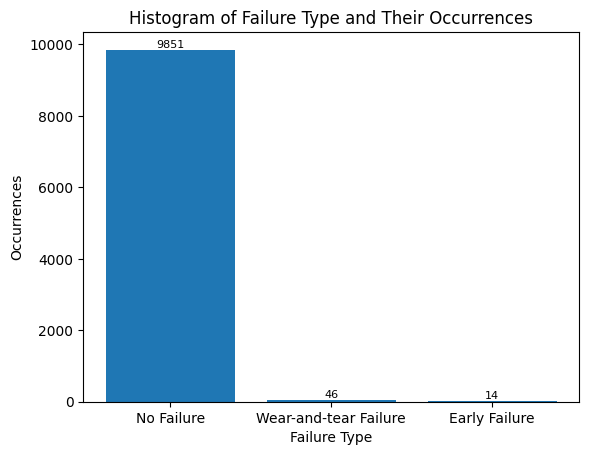

In [694]:
# Convert the dictionary to lists for plotting
failure_key = list(failure_count.keys())
failure_value = list(failure_count.values())

# Plot the histogram
plt.bar(failure_key, failure_value)
plt.xlabel('Failure Type')
plt.ylabel('Occurrences')
plt.title('Histogram of Failure Type and Their Occurrences')
plt.xticks(rotation=0)  # To rotate x-axis labels for better visibility

# Annotate each bar with its corresponding value
for i, v in enumerate(failure_value):
    plt.text(i, v, str(v), ha='center', va='bottom', fontsize=8)

plt.show()


Conclusion:
+ The majority of data is No Failure (9851).
+ Only 46 and 14 are Wear-and-tear and Early Failure, respectively.
+ There is a big imbalance.

### Early Failure vs Wear-and-tear Failure

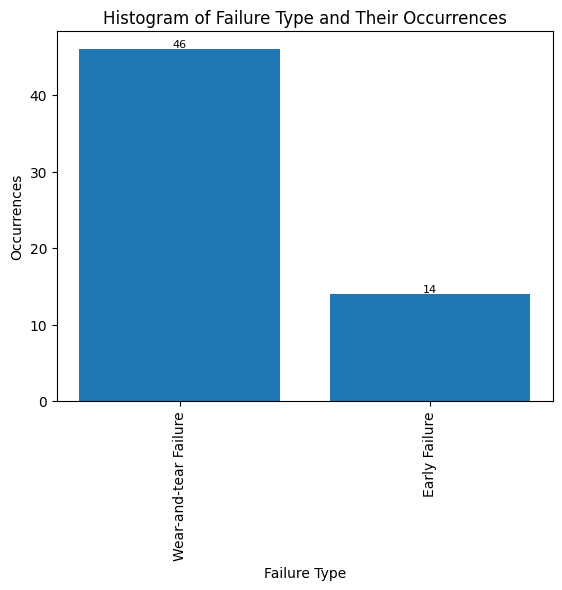

In [695]:
# Pop No Failure out of the dictionary
failure_count.pop('No Failure', None)
# Convert the dictionary to lists for plotting
failure_key = list(failure_count.keys())
failure_value = list(failure_count.values())

# Plot the histogram
plt.bar(failure_key, failure_value)
plt.xlabel('Failure Type')
plt.ylabel('Occurrences')
plt.title('Histogram of Failure Type and Their Occurrences')
plt.xticks(rotation=90)  # To rotate x-axis labels for better visibility

# Annotate each bar with its corresponding value
for i, v in enumerate(failure_value):
    plt.text(i, v, str(v), ha='center', va='bottom', fontsize=8)

plt.show()


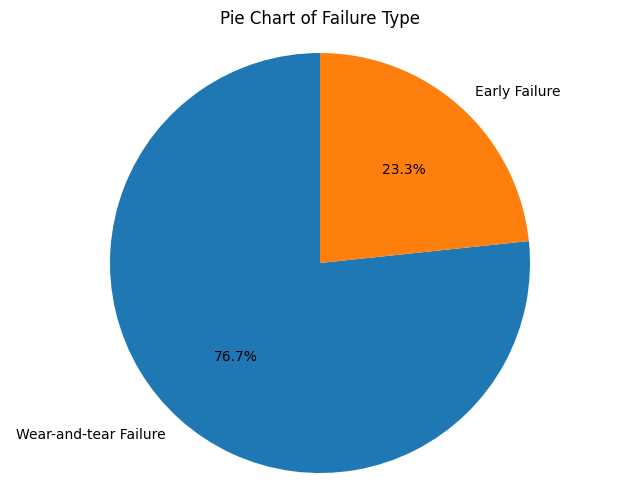

In [696]:
# Plot the pie chart
plt.figure(figsize=(8, 6))
plt.pie(failure_value, labels=failure_key, autopct='%1.1f%%', startangle=90)

plt.title('Pie Chart of Failure Type')
plt.axis('equal')  

plt.show()

Conclusion: The majority of failure is the Wear-and-tear Failure 

## Visualisation Function

In [697]:
def barchart_visualisation(column_name):
    no_failure_df = merged_df.loc[merged_df["Fail Flag"] == False]
    no_failure_key_of_columname = set(no_failure_df[column_name])

    total_failure_df = merged_df.loc[merged_df["Fail Flag"] == True]
    total_count = total_failure_df[column_name].value_counts()
    total_count = total_count.to_dict()

    early_failure_df = merged_df.loc[merged_df["Failure Type"] == "Early Failure"]
    earlyfail_count = early_failure_df[column_name].value_counts()
    earlyfail_count = earlyfail_count.to_dict()

    wear_tear_failure_df = merged_df.loc[merged_df["Failure Type"] == "Wear-and-tear Failure"]
    wear_tear_count = wear_tear_failure_df[column_name].value_counts()
    wear_tear_count = wear_tear_count.to_dict()

    total_keys = set(list(total_count.keys()))
    
    # Get the corresponding values for each manufacturer key in the correct order
    total_fail_values = [total_count.get(key, 0) for key in total_keys]
    earlyfail_values = [earlyfail_count.get(key, 0) for key in total_keys]
    wear_tear_values = [wear_tear_count.get(key, 0) for key in total_keys]

    # Set the figure size
    plt.figure(figsize=(10, 6))

    # Define the width of each bar and the gap between each pair of bars
    bar_width = 0.2
    bar_gap = 0.05

    # Create the x-axis positions for each group of bars
    x_positions = np.arange(len(total_keys))

    # Plot the bars in the order (total, early, wear-and-tear)
    plt.bar(x_positions, total_fail_values, bar_width, label='Total Failures')
    plt.bar(x_positions + bar_width + bar_gap, earlyfail_values, bar_width, label='Early Failures')
    plt.bar(x_positions + 2 * (bar_width + bar_gap), wear_tear_values, bar_width, label='Wear-and-tear Failures')

    # Set x-axis labels
    plt.xticks(x_positions + bar_width, total_keys, rotation=90)

    # Add labels and title
    plt.xlabel(column_name)
    plt.ylabel('Number of Failures')
    plt.title(f'Number of Failures by {column_name}')
    plt.legend()

    # Add text annotations for each bar
    for i in range(len(total_keys)):
        plt.text(x_positions[i], total_fail_values[i], str(total_fail_values[i]), ha='center', va='bottom')
        plt.text(x_positions[i] + bar_width + bar_gap, earlyfail_values[i], str(earlyfail_values[i]), ha='center', va='bottom')
        plt.text(x_positions[i] + 2 * (bar_width + bar_gap), wear_tear_values[i], str(wear_tear_values[i]), ha='center', va='bottom')

    # Show the plot
    plt.show()

    # Find the variable that does not have failure
    no_failure = no_failure_key_of_columname.difference(total_keys)
    
    if len(no_failure) > 0:
        print(f'The {column_name} has no fail are:', no_failure)
    else:
        print(f'All {column_name} observed Fail')

### Failure Type vs Type of Equipment

In [698]:
set(merged_df["TYPE"])

{'Power Transformer',
 'Power autotransformer',
 'Regulator Power Autotransformer',
 'Transformer (Mobile SS remote control)'}

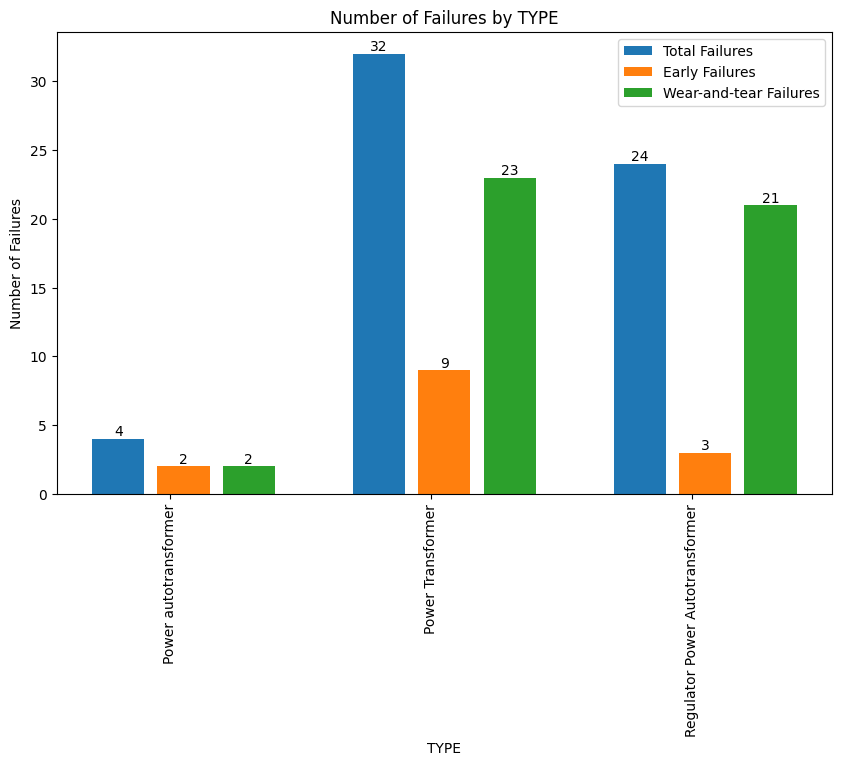

The TYPE has no fail are: {'Transformer (Mobile SS remote control)'}


In [699]:
barchart_visualisation("TYPE")

Conclusion: 
+ Power Transformer has the highest number of failures in both failure types.
+ Power autotransformer has the smallest number of failures in both failure types.

### Failure Type vs AREA

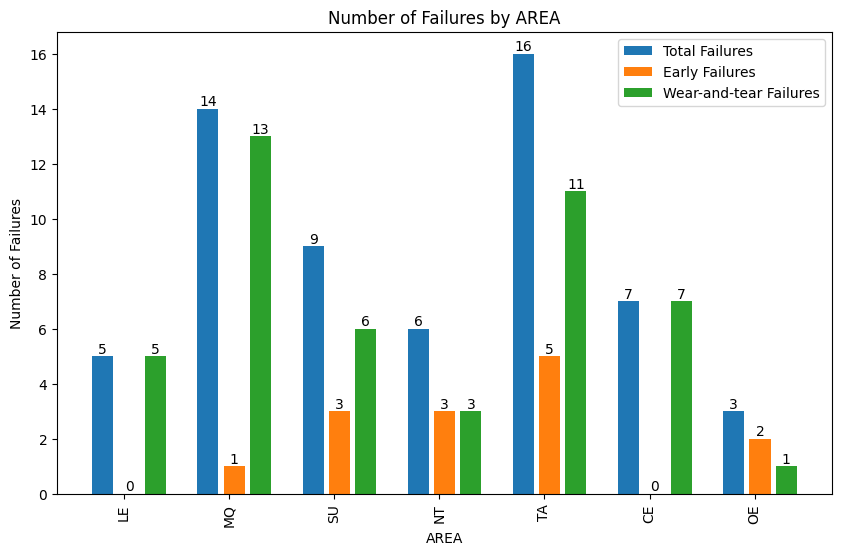

All AREA observed Fail


In [700]:
barchart_visualisation("AREA")

Conclusion: 
+ For Wear-and-tear Failure, MQ has the highest number (17) and OE has the lowest number (1). <br>
+ For Early Failure, TA has the highest number (5) and both CE and LE has the lowest number (0).

## Failure vs MANUFACTURER

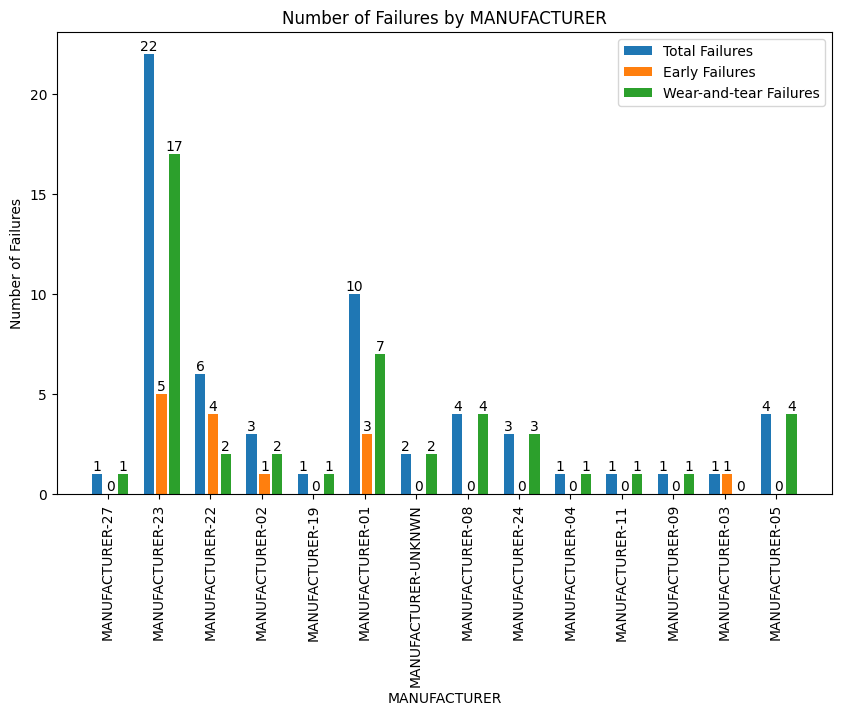

The MANUFACTURER has no fail are: {'MANUFACTURER-10', 'MANUFACTURER-14', 'MANUFACTURER-26', 'MANUFACTURER-13', 'MANUFACTURER-07', 'MANUFACTURER-25', 'MANUFACTURER-12'}


In [701]:
barchart_visualisation("MANUFACTURER")

Conclusion:
+ For Total Failure, MANUFACTURER-23 has the highest number. MANUFACTURER-04, MANUFACTURER-09, MANUFACTURER-03, MANUFACTURER-19, MANUFACTURER-27, MANUFACTURER-11 have the smallest number of Total Failure.
+ For Early Failure, MANUFACTURER-23 has the highest number.
+ For Wear-and-tear Failure, MANUFACTURER-04, MANUFACTURER-09, MANUFACTURER-19, MANUFACTURER-27, and MANUFACTURER-11 have the small number.

## Number of Failure over time

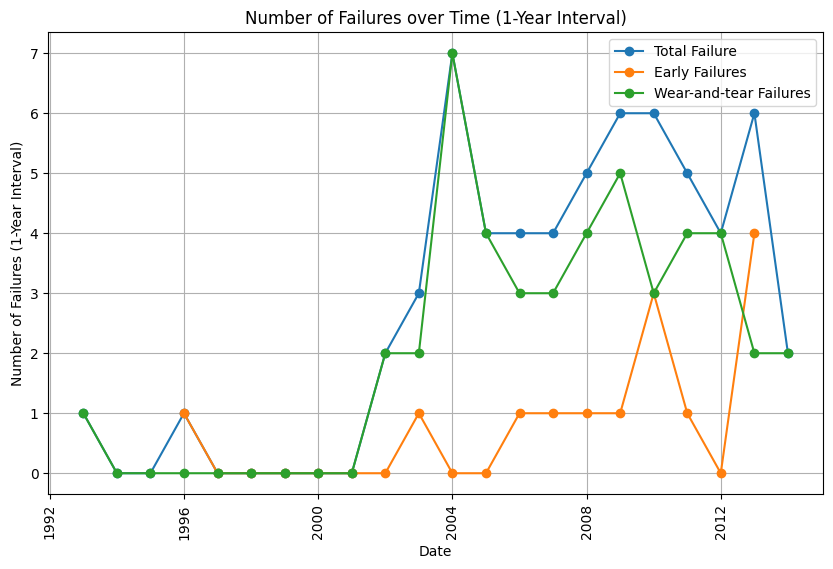

In [702]:
# Create a new DataFrame to count the number of failures by date
#no_failure_counts = merged_df[merged_df['Fail Flag'] == False]['Op Date'].value_counts().sort_index()
failure_counts = merged_df[merged_df['Fail Flag'] == True]['Op Date'].value_counts().sort_index()
earlyfail_counts = merged_df[merged_df['Failure Type'] == "Early Failure"]['Op Date'].value_counts().sort_index()
wear_tear_fail_counts = merged_df[merged_df['Failure Type'] == "Wear-and-tear Failure"]['Op Date'].value_counts().sort_index()

# Resample the data to aggregate failures over a 1-year period
#no_failure_counts_resampled = no_failure_counts.resample('1Y').sum()
failure_counts_resampled = failure_counts.resample('1Y').sum()
earlyfail_counts_resampled = earlyfail_counts.resample('1Y').sum()
wear_tear_fail_counts_resampled = wear_tear_fail_counts.resample('1Y').sum()

# Create the time series plot
plt.figure(figsize=(10, 6))
#plt.plot(no_failure_counts_resampled.index, no_failure_counts_resampled.values, marker='o', linestyle='-', label="No Failure")
plt.plot(failure_counts_resampled.index, failure_counts_resampled.values, marker='o', linestyle='-', label="Total Failure")
plt.plot(earlyfail_counts_resampled.index, earlyfail_counts_resampled.values, marker='o', linestyle='-', label="Early Failures")
plt.plot(wear_tear_fail_counts_resampled.index, wear_tear_fail_counts_resampled.values, marker='o', linestyle='-', label="Wear-and-tear Failures")
plt.xlabel('Date')
plt.ylabel('Number of Failures (1-Year Interval)')
plt.title('Number of Failures over Time (1-Year Interval)')
plt.grid(True)
plt.xticks(rotation=90)
plt.legend()  # Add legend to show labels
plt.show()



Conclusion:
+ Number of Failure fluctuated over time.
+ Year of 2004 observed the highest number of Total Failure causing by only Wear-and-tear Failure.


## Failure vs PHASES

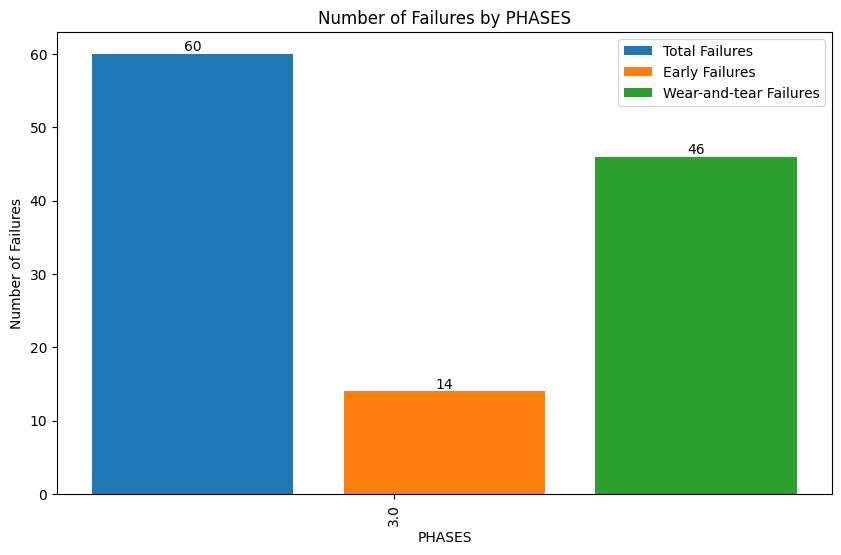

The PHASES has no fail are: {1.0}


In [703]:
barchart_visualisation("PHASES")

Conclusion:
+ Both Failure Types only observe in PHASE 3
+ Wear-and-tear Failure is the main failure type

## Failure Type vs POWER (MVA)

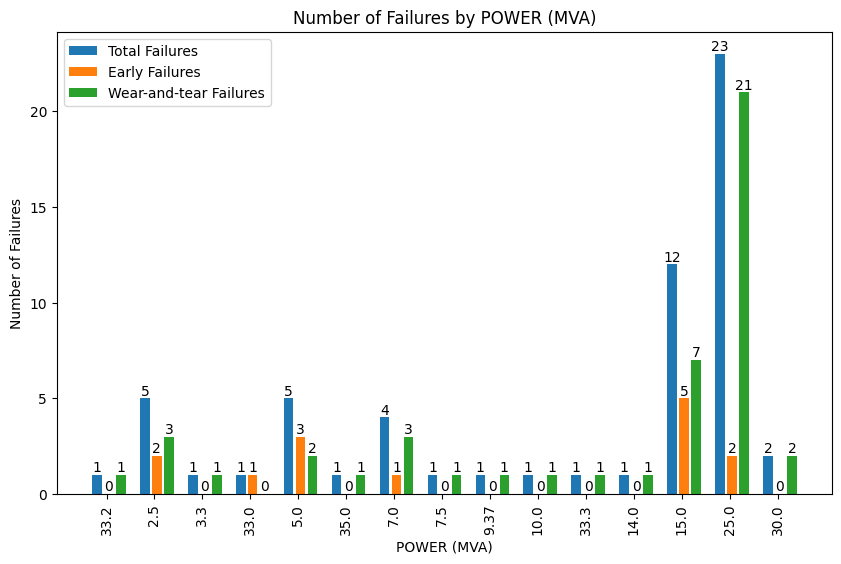

The POWER (MVA) has no fail are: {0.22, 1.0, 1.25, 1.5, 2.0, 2.25, 6.6, 6.25, 7.6, 9.0, 4.2, 12.5, 13.3}


In [704]:
barchart_visualisation("POWER (MVA)")

Conlcusion:
+ The POWER (MVA) of 25.0 produced the highest number of Total Failure and Wear-and-tear Failure

## Failure Type vs VOLTAGE REGULATION

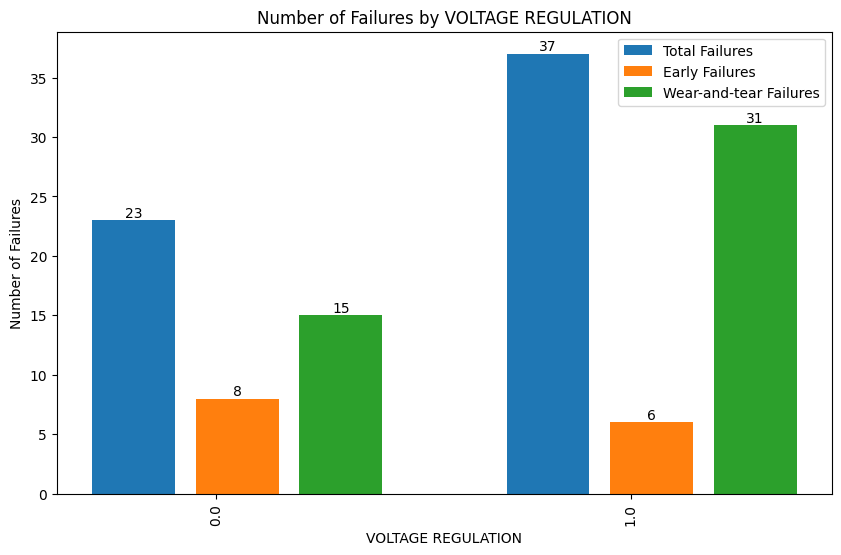

All VOLTAGE REGULATION observed Fail


In [705]:
barchart_visualisation("VOLTAGE REGULATION")

Conclusion
+ VOLTAGE REGULATION of 1.0 had the highest number of total failures (37) and Wear-and-tear Failures (31). V
+ VOLTAGTAGE REGULATION of 0.0 had the highest number of Early Failure (8).

## Failure Type vs NOMINAL VOLTAGE (KV)

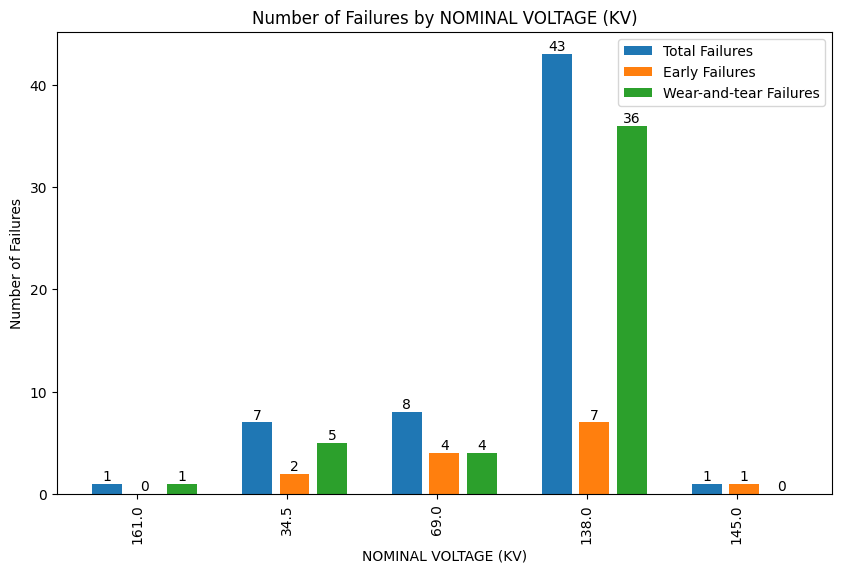

The NOMINAL VOLTAGE (KV) has no fail are: {72.5, 144.9, 13.8, 22.0}


In [706]:
barchart_visualisation("NOMINAL VOLTAGE (KV)")

Conclusion:
+ NOMIAL VOLTAGE of 128.0 KV had the highest number of total failures (43), Wear-and-tear Failure (36) and Early Failure (7).
+ NOMINAL VOLTAGE of 72.5, 144.9, 13.8 and 22.0 experienced no failures.

## Failure Type vs FUNCTION

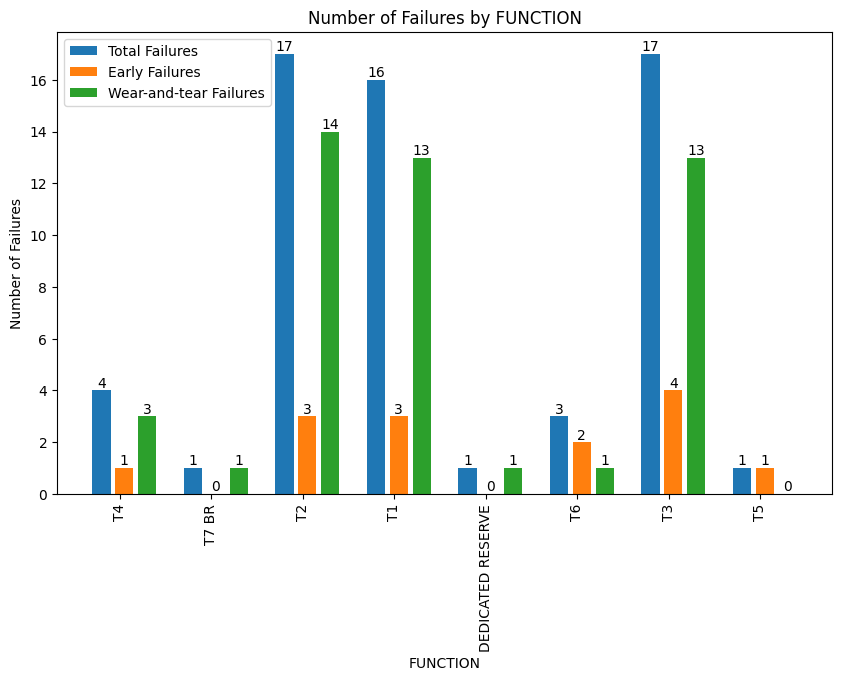

The FUNCTION has no fail are: {'T7', 'T11', 'T7 RESERVE', 'IMMOB RESERVE', 'T14', 'T8', 'T1_AZ', 'T7 VM', 'T13', 'T25', 'T7 AZ'}


In [707]:
barchart_visualisation("FUNCTION")

Conclusion
+ Both T2 and T3 FUNCTIONS had the highest number of total failures (17). 
+ T2 FUNCTION had the highest number of Wear-and-tear Failure (14), followed by T1 and T3, both had 13. 
+ For Early Failure, T3 experienced the highest number with 4. 

# Encode Data

In [708]:
# Drop Area Code column since it is redundant
merged_df.drop(columns=['Area Code'], inplace=True)

In [709]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
merged_df["TYPE"] = label_encoder.fit_transform(merged_df["TYPE"])
merged_df["AREA"] = label_encoder.fit_transform(merged_df["AREA"])
merged_df["FUNCTION"] = label_encoder.fit_transform(merged_df["FUNCTION"])
merged_df["MANUFACTURER"] = label_encoder.fit_transform(merged_df["MANUFACTURER"])

# Mutual Information

In [724]:
import pandas as pd
from sklearn.feature_selection import mutual_info_classif
import seaborn as sns

def mutual_information_cal(target_value):
    '''
    This function is to find the Mutual Information score
    of different features contributing to detect failure type
    -------------------------
    Parameter:
    targer_value: EarlyFailure'''
    # Create a new DataFrame for mutual information analysis
    mi_analyse_df = merged_df[['TYPE', 'AREA', 'FUNCTION', 'MANUFACTURER',
                                'PHASES', 'POWER (MVA)', 'VOLTAGE REGULATION',
                                'NOMINAL VOLTAGE (KV)', 'Used Year', 'Failure Type']]
    if target_value == "EarlyFailure":
        mi_analyse_df["Failure Type"] = np.where(mi_analyse_df["Failure Type"] != "Early Failure", "Others", mi_analyse_df["Failure Type"])
    elif target_value == "Wear-and-tearFailure":
        mi_analyse_df["Failure Type"] = np.where(mi_analyse_df["Failure Type"] != "Wear-and-tear Failure", "Others", mi_analyse_df["Failure Type"])
    elif target_value == "All":
        mi_analyse_df = mi_analyse_df.copy()
    # Separate the features (X) and the target variable (y)
    X = mi_analyse_df.drop(columns=['Failure Type'])
    y = mi_analyse_df['Failure Type']

    # Calculate the mutual information scores between each feature and the target variable
    mutual_info_scores = mutual_info_classif(X, y, random_state=42)

    # Create a DataFrame to store the results
    mi_df = pd.DataFrame({'Feature': X.columns, 'Mutual Information Score': mutual_info_scores})
    mi_df.sort_values(by='Mutual Information Score', ascending=False, inplace=True)
    
    # Set the 'Feature' column as the index of the DataFrame
    mi_df.set_index('Feature', inplace=True)
    display(mi_df)
    # Plot the heatmap
    plt.figure(figsize=(10, 6))
    sns.heatmap(data=mi_df, xticklabels=True, yticklabels=True, cmap='coolwarm', annot=True, fmt='.6f')
    plt.title('Mutual Information Scores')
    plt.xlabel('Features')
    plt.show()



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Mutual Information Score
Feature,
Used Year,0.003590
PHASES,0.002125
AREA,0.001457
MANUFACTURER,0.000944
NOMINAL VOLTAGE (KV),0.000920
VOLTAGE REGULATION,0.000836
FUNCTION,0.000647
POWER (MVA),0.000513
TYPE,0.000103


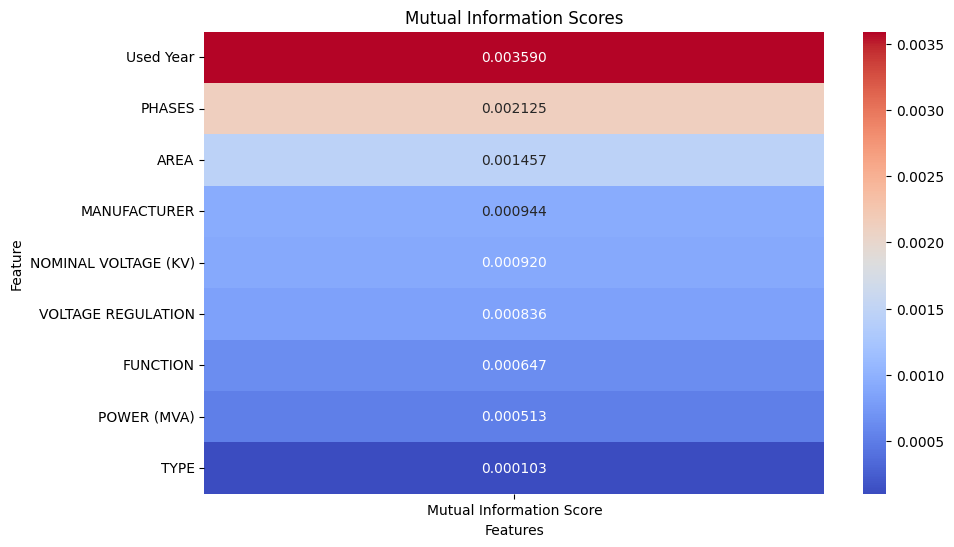

In [725]:
mutual_information_cal("EarlyFailure")


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Mutual Information Score
Feature,
PHASES,0.002312
NOMINAL VOLTAGE (KV),0.002013
Used Year,0.001785
FUNCTION,0.001662
AREA,0.001050
POWER (MVA),0.000993
TYPE,0.000524
MANUFACTURER,0.000376
VOLTAGE REGULATION,0.000053


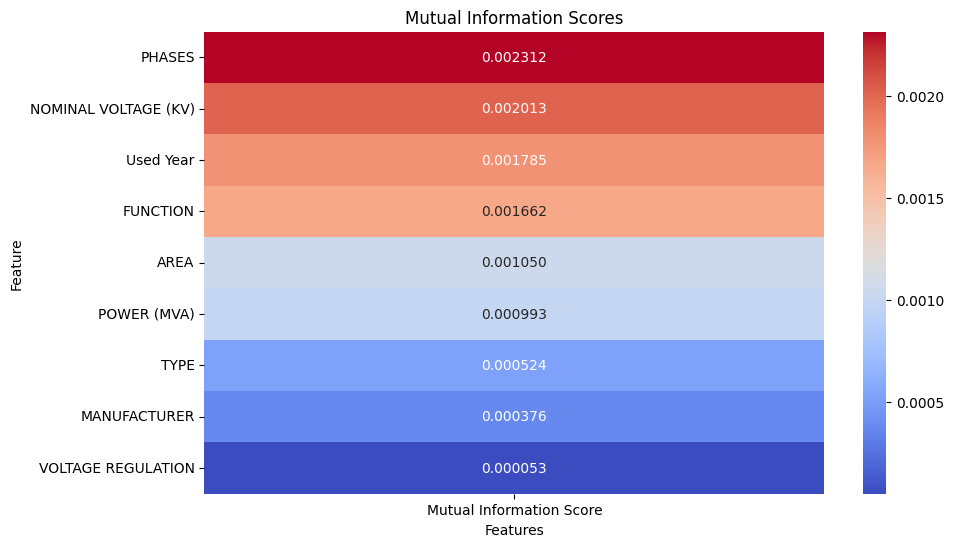

In [726]:
mutual_information_cal("Wear-and-tearFailure")

,Mutual Information Score
Feature,
Used Year,0.005369
PHASES,0.002210
FUNCTION,0.002009
NOMINAL VOLTAGE (KV),0.001908
AREA,0.001795
MANUFACTURER,0.001111
POWER (MVA),0.001020
VOLTAGE REGULATION,0.000412
TYPE,0.000317


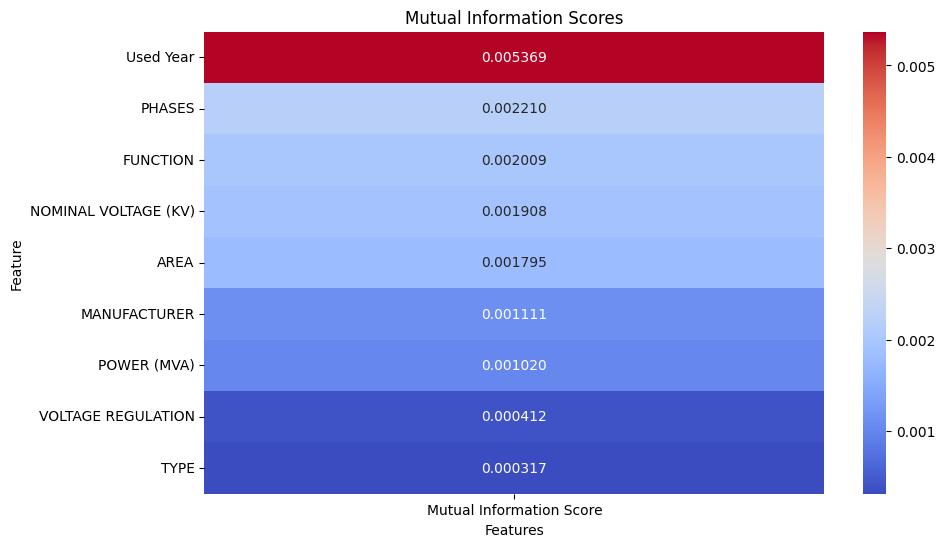

In [727]:
mutual_information_cal("All")

# Preprocess and Split data

In [847]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# Step 1: Apply SMOTE
merged_df_2 = merged_df[['TYPE', 'AREA', 'FUNCTION', 'MANUFACTURER',
       'PHASES', 'POWER (MVA)', 'VOLTAGE REGULATION',
       'NOMINAL VOLTAGE (KV)', 'Used Year',
       'Failure Type']]

Failure_type_map = {"No Failure": 0,
                    "Early Failure": 1,
                    "Wear-and-tear Failure": 2}
merged_df_2['Failure Type'] = merged_df_2['Failure Type'].replace(Failure_type_map)

X = merged_df_2.drop(columns=['Failure Type'])
y = merged_df_2['Failure Type']

smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X, y)

# Step 2: Preprocess the Data into 0-1 Scale
scaler = MinMaxScaler()

# Fit and transform the features X_balanced
X_balanced_scaled = scaler.fit_transform(X_balanced)

# Step 3: Split data
X_train, X_test, y_train, y_test = train_test_split(X_balanced_scaled, y_balanced, test_size=0.2, random_state=42)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Number of each class after SMOTE applying

In [848]:
class_dict = {}
for i in y_balanced:
    class_dict[i] = y_balanced.to_list().count(i)
class_dict

{0: 9851, 1: 9851, 2: 9851}

In [849]:
print("Size of training set:", len(X_train))
print("Size of testing set:", len(X_test))

Size of training set: 23642
Size of testing set: 5911


# Deep Learning Model

In [850]:
import tensorflow as tf
from tensorflow.keras import layers, models
import random

# Set a random seed for reproducibility
random.seed(4)
tf.random.set_seed(4)

# Build a Simple Deep Learning Model with L1 regularization
DL_model = models.Sequential([
    layers.Dense(X_train.shape[1], activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dense(128, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(3, activation='softmax')  # 3 output classes for 'No Failure', 'Early Failure', 'Wear-and-tear Failure'
])

# Compile the model
DL_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
DL_model.summary()

# Train the model
history = DL_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)


Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_60 (Dense)            (None, 9)                 90        
                                                                 
 dense_61 (Dense)            (None, 128)               1280      
                                                                 
 dense_62 (Dense)            (None, 128)               16512     
                                                                 
 dense_63 (Dense)            (None, 3)                 387       
                                                                 
Total params: 18,269
Trainable params: 18,269
Non-trainable params: 0
_________________________________________________________________


Epoch 1/20


The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.


592/592 [==============================] - 1s 1ms/step - loss: 0.5740 - accuracy: 0.7416 - val_loss: 0.4574 - val_accuracy: 0.8103
Epoch 2/20
592/592 [==============================] - 1s 1ms/step - loss: 0.3694 - accuracy: 0.8374 - val_loss: 0.3634 - val_accuracy: 0.8368
Epoch 3/20
592/592 [==============================] - 1s 1ms/step - loss: 0.3191 - accuracy: 0.8641 - val_loss: 0.3560 - val_accuracy: 0.8507
Epoch 4/20
592/592 [==============================] - 1s 1ms/step - loss: 0.2869 - accuracy: 0.8828 - val_loss: 0.2833 - val_accuracy: 0.8835
Epoch 5/20
592/592 [==============================] - 1s 1ms/step - loss: 0.2594 - accuracy: 0.8953 - val_loss: 0.3136 - val_accuracy: 0.8509
Epoch 6/20
592/592 [==============================] - 1s 1ms/step - loss: 0.2414 - accuracy: 0.9048 - val_loss: 0.2354 - val_accuracy: 0.9051
Epoch 7/20
592/592 [==============================] - 1s 1ms/step - loss: 0.2260 - accuracy: 0.9112 - val_loss: 0.2137 - val_accuracy: 0.9169
Epoch 8/20
592/59

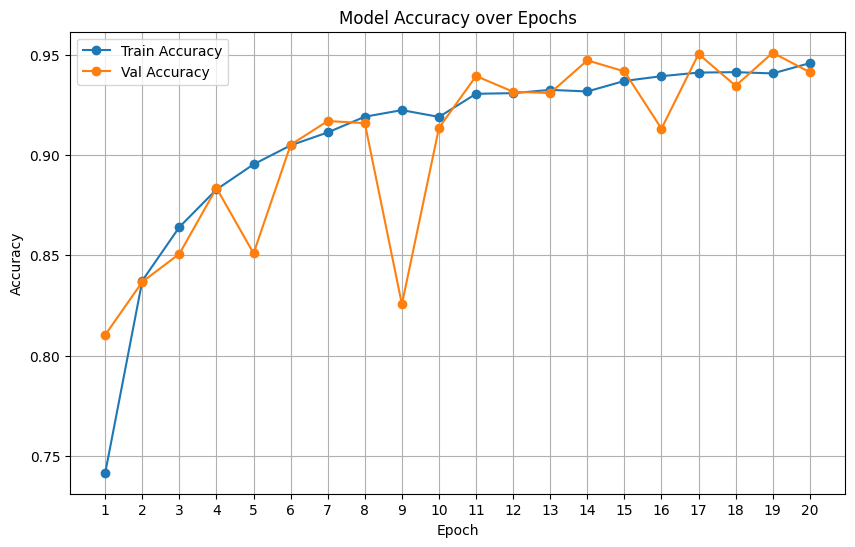

In [851]:
# Extract accuracy values for train and test sets from the history object
train_accuracy = history.history['accuracy']
test_accuracy = history.history['val_accuracy']

# Plot the accuracy over epochs
plt.figure(figsize=(10, 6))
plt.plot(range(1, 21), train_accuracy, label='Train Accuracy', marker='o')
plt.plot(range(1, 21), test_accuracy, label='Val Accuracy', marker='o')
plt.title('Model Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(range(1, 21))
plt.legend()
plt.grid(True)
plt.show()

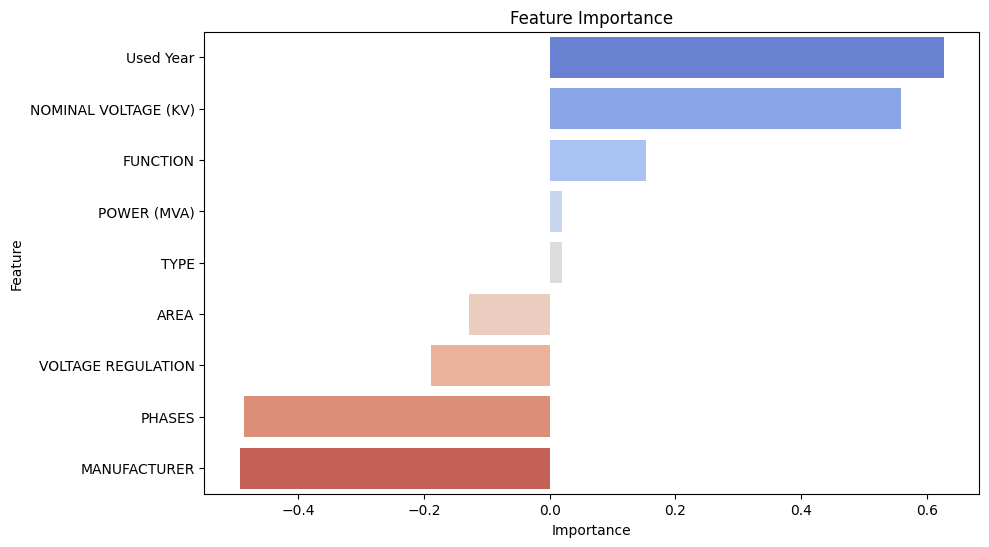

In [855]:
# Evaluate Feature Importance
input_layer_weights = DL_model.layers[0].get_weights()[0]

feature_importance_DL_df = pd.DataFrame({'Feature': X.columns, 'Importance': input_layer_weights[0]})
feature_importance_DL_df = feature_importance_DL_df.sort_values(by='Importance', ascending=False)

# Plot the feature importance
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance_DL_df, x='Importance', y='Feature', palette='coolwarm')
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

In [857]:
import shap

# Create a SHAP DeepExplainer for the Deep Learning model
background_sample = X_train[np.random.choice(X_train.shape[0], 1000, replace=False)]
explainer = shap.DeepExplainer(DL_model, background_sample)

# Compute SHAP values for the test set
shap_values = explainer.shap_values(X_test)

# Get the original feature names
original_feature_names = X.columns

# Map the class indices to class names
class_names = ['No Failure', 'Early Failure', 'Wear-and-tear Failure']

# Create a DataFrame with the SHAP values and original feature names
shap_values_df = pd.DataFrame(shap_values[0], columns=original_feature_names)

# Convert class indices to class names using the LabelEncoder
label_encoder = LabelEncoder()
y_test_encoded = label_encoder.fit_transform(y_test)

# Map the class indices to class names using a dictionary
class_names_dict = {i: class_name for i, class_name in enumerate(class_names)}
shap_values_df['Failure Type'] = y_test_encoded
shap_values_df['Failure Type'] = shap_values_df['Failure Type'].map(class_names_dict)


Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


SHAP value for Early Failure

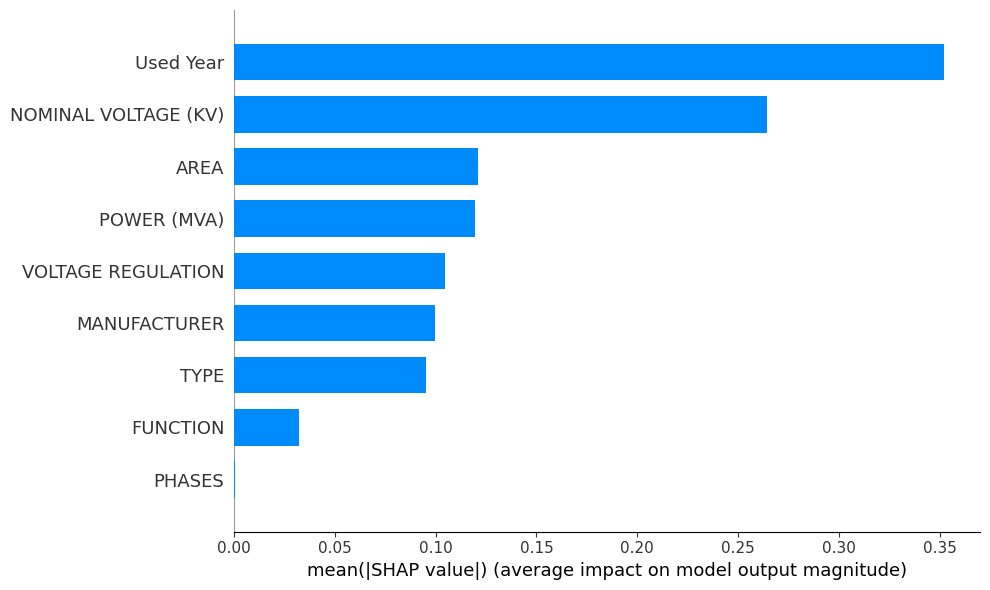

In [858]:
shap.summary_plot(shap_values[1], X_test, feature_names=original_feature_names, class_names=class_names[1], plot_type='bar', plot_size=(10, 6))

SHAP value for Wear-and-tear Failure

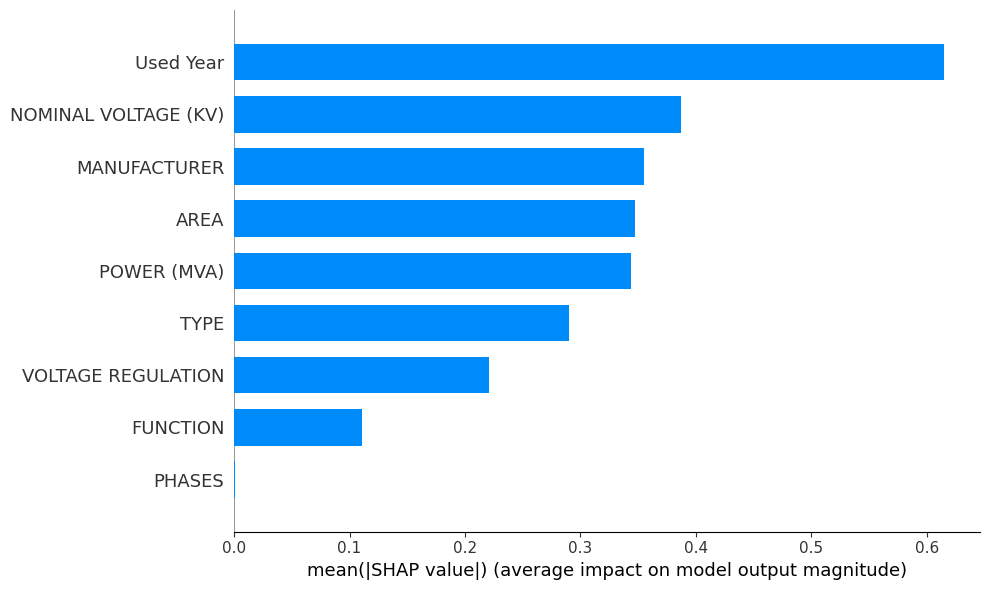

In [859]:
shap.summary_plot(shap_values[2], X_test, feature_names=original_feature_names, class_names=class_names[2], plot_type='bar', plot_size=(10, 6))

Recall, Precision and F1-score 

 60/185 [========>.....................] - ETA: 0s

185/185 [==============================] - 0s 942us/step


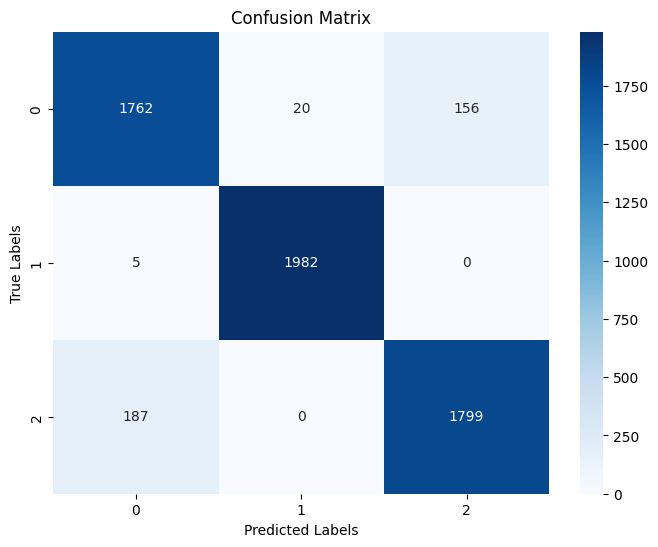

,Class,Precision,Recall,F1-Score
0,No Failure,0.901740,0.909185,0.905447
1,Early Failure,0.990010,0.997484,0.993733
2,Wear-and-tear Failure,0.920205,0.905841,0.912966


In [860]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Evaluate the Model
y_pred_probs = DL_model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Calculate precision, recall, and F1-score for each class
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

precision_no_failure = precision_score(y_test, y_pred, average='weighted', labels=[0])
precision_early_failure = precision_score(y_test, y_pred, average='weighted', labels=[1])
precision_wear_tear_failure = precision_score(y_test, y_pred, average='weighted', labels=[2])

recall_no_failure = recall_score(y_test, y_pred, average='weighted', labels=[0])
recall_early_failure = recall_score(y_test, y_pred, average='weighted', labels=[1])
recall_wear_tear_failure = recall_score(y_test, y_pred, average='weighted', labels=[2])

f1_no_failure = f1_score(y_test, y_pred, average='weighted', labels=[0])
f1_early_failure = f1_score(y_test, y_pred, average='weighted', labels=[1])
f1_wear_tear_failure = f1_score(y_test, y_pred, average='weighted', labels=[2])

# Create a DataFrame to store the metrics
metrics_DL_df = pd.DataFrame({
    'Class': ['No Failure', 'Early Failure', 'Wear-and-tear Failure'],
    'Precision': [precision_no_failure, precision_early_failure, precision_wear_tear_failure],
    'Recall': [recall_no_failure, recall_early_failure, recall_wear_tear_failure],
    'F1-Score': [f1_no_failure, f1_early_failure, f1_wear_tear_failure]
})

# Step 7: Visualize Confusion Matrix
confusion_mtx = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
display(metrics_DL_df)

# Random Forest

,Class,Precision,Recall,F1-Score
0,No Failure,0.976507,0.986584,0.981520
1,Early Failure,0.996482,0.997987,0.997234
2,Wear-and-tear Failure,0.990321,0.978852,0.984553


,Feature,Importance
8,Used Year,0.485129
5,POWER (MVA),0.120064
2,FUNCTION,0.106747
1,AREA,0.097543
3,MANUFACTURER,0.081928
7,NOMINAL VOLTAGE (KV),0.044782
6,VOLTAGE REGULATION,0.035332
0,TYPE,0.027779
4,PHASES,0.000697


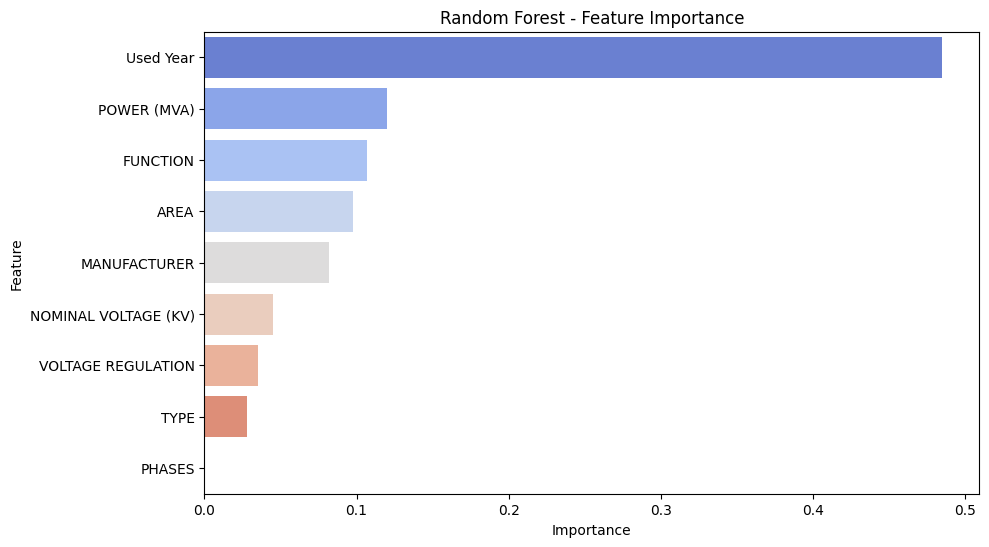

In [760]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Build the Random Forest Model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Evaluate the Model
y_pred = rf_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Calculate precision, recall, and F1-score for each class
precision_no_failure = precision_score(y_test, y_pred, average='weighted', labels=[0])
precision_early_failure = precision_score(y_test, y_pred, average='weighted', labels=[1])
precision_wear_tear_failure = precision_score(y_test, y_pred, average='weighted', labels=[2])

recall_no_failure = recall_score(y_test, y_pred, average='weighted', labels=[0])
recall_early_failure = recall_score(y_test, y_pred, average='weighted', labels=[1])
recall_wear_tear_failure = recall_score(y_test, y_pred, average='weighted', labels=[2])

f1_no_failure = f1_score(y_test, y_pred, average='weighted', labels=[0])
f1_early_failure = f1_score(y_test, y_pred, average='weighted', labels=[1])
f1_wear_tear_failure = f1_score(y_test, y_pred, average='weighted', labels=[2])

# Create a DataFrame to store the metrics
metrics_rf_df = pd.DataFrame({
    'Class': ['No Failure', 'Early Failure', 'Wear-and-tear Failure'],
    'Precision': [precision_no_failure, precision_early_failure, precision_wear_tear_failure],
    'Recall': [recall_no_failure, recall_early_failure, recall_wear_tear_failure],
    'F1-Score': [f1_no_failure, f1_early_failure, f1_wear_tear_failure]
})

display(metrics_rf_df)

# Feature Importance
feature_importance = rf_model.feature_importances_
feature_importance_rf_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importance})
feature_importance_rf_df = feature_importance_rf_df.sort_values(by='Importance', ascending=False)
display(feature_importance_rf_df)

# Plot the feature importance
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance_rf_df, x='Importance', y='Feature', palette='coolwarm')
plt.title('Random Forest - Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


In [761]:
y_train_pred = rf_model.predict(X_train)
y_test_pred = rf_model.predict(X_test)

# Calculate accuracy on training and test data
accuracy_train = accuracy_score(y_train, y_train_pred)
accuracy_test = accuracy_score(y_test, y_test_pred)

print("Accuracy on Training Data:", accuracy_train)
print("Accuracy on Test Data:", accuracy_test)

Accuracy on Training Data: 1.0
Accuracy on Test Data: 0.9878193199120284


In [774]:
import shap

# Create a SHAP TreeExplainer for the Random Forest model 
explainer = shap.TreeExplainer(rf_model)

# Compute SHAP values for the test set
shap_values = explainer.shap_values(X_test)

# Get the original feature names
original_feature_names = X.columns

# Map the class indices to class names
class_names = ['No Failure', 'Early Failure', 'Wear-and-tear Failure']


In [ ]:
# Create a DataFrame with the SHAP values and original feature names
shap_values_df = pd.DataFrame(shap_values[0], columns=original_feature_names)

# Convert class indices to class names using the LabelEncoder
label_encoder = LabelEncoder()
y_test_encoded = label_encoder.fit_transform(y_test)

# Map the class indices to class names using a dictionary
class_names_dict = {i: class_name for i, class_name in enumerate(class_names)}
shap_values_df['Failure Type'] = y_test_encoded
shap_values_df['Failure Type'] = shap_values_df['Failure Type'].map(class_names_dict)


Shap value for Early Failure

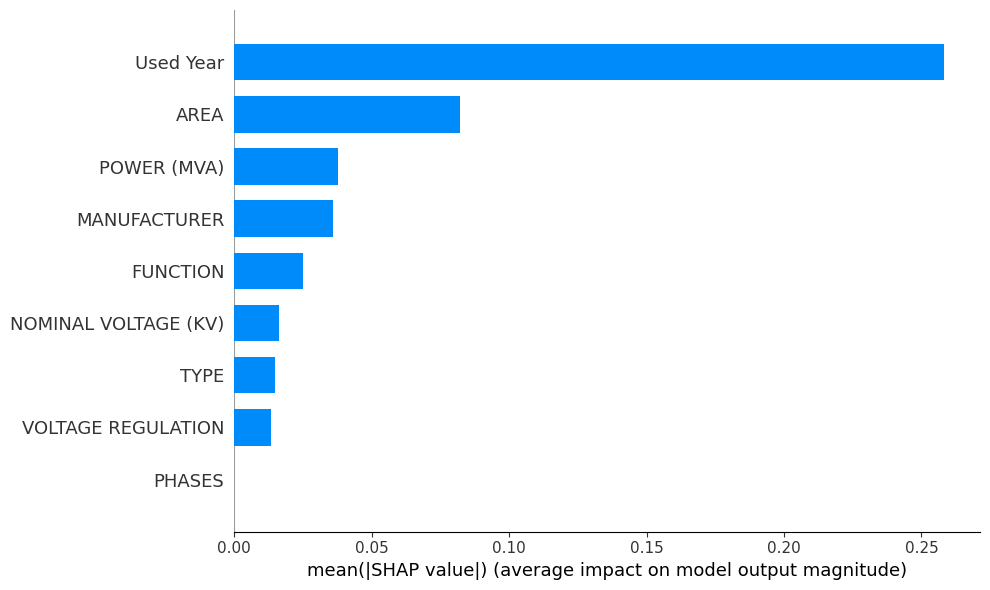

In [780]:
# Display the SHAP summary plot for detecting Early Failure
shap.summary_plot(shap_values[1], X_test, feature_names=original_feature_names, class_names=class_names[1], plot_type='bar', plot_size=(10, 6))

Shap value for Wear-and-tear Failure

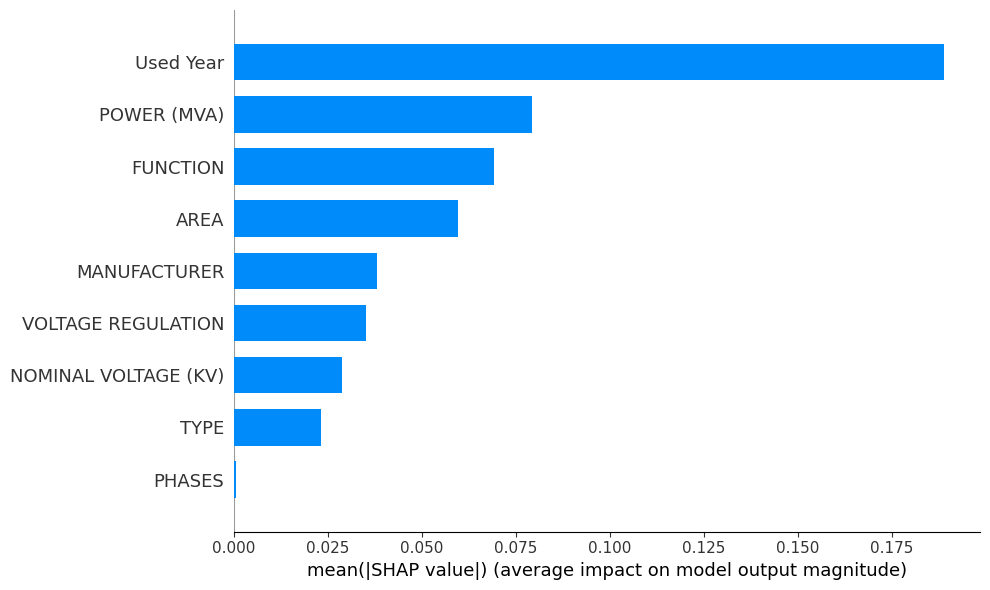

In [781]:
# Display the SHAP summary plot for detecting Wear-and-tear Failure
shap.summary_plot(shap_values[2], X_test, feature_names=original_feature_names, class_names=class_names[2], plot_type='bar', plot_size=(10, 6))

# Recursive Feature Elimination 

In [890]:
from sklearn.svm import SVC
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score

# Initialize the SVM model
svm_model = SVC(kernel='linear')

# Initialize RFE and set the desired number of features to keep
num_features_to_keep = 5  # the desired number of important features 
rfe = RFE(estimator=svm_model, n_features_to_select=num_features_to_keep)

# Fit RFE on the training data to find important features
rfe.fit(X_train, y_train)

# Get the selected features
selected_features = rfe.support_
important_feature_names = X.columns[selected_features]

# Train SVM model on the selected features
X_train_selected = X_train[:, selected_features]
X_test_selected = X_test[:, selected_features]

svm_model.fit(X_train_selected, y_train)


from sklearn.metrics import precision_score, recall_score, f1_score

# Make predictions on the test set using the SVM model with selected features
y_pred = svm_model.predict(X_test_selected)

# Calculate recall, precision, and F1 score for each class
recall_no_failure = recall_score(y_test, y_pred, average='weighted', labels=[0])
recall_early_failure = recall_score(y_test, y_pred, average='weighted', labels=[1])
recall_wear_tear_failure = recall_score(y_test, y_pred, average='weighted', labels=[2])

precision_no_failure = precision_score(y_test, y_pred, average='weighted', labels=[0])
precision_early_failure = precision_score(y_test, y_pred, average='weighted', labels=[1])
precision_wear_tear_failure = precision_score(y_test, y_pred, average='weighted', labels=[2])

f1_no_failure = f1_score(y_test, y_pred, average='weighted', labels=[0])
f1_early_failure = f1_score(y_test, y_pred, average='weighted', labels=[1])
f1_wear_tear_failure = f1_score(y_test, y_pred, average='weighted', labels=[2])

# Create a DataFrame to store the metrics
metrics_svm_df = pd.DataFrame({
    'Class': ['No Failure', 'Early Failure', 'Wear-and-tear Failure'],
    'Precision': [precision_no_failure, precision_early_failure, precision_wear_tear_failure],
    'Recall': [recall_no_failure, recall_early_failure, recall_wear_tear_failure],
    'F1-Score': [f1_no_failure, f1_early_failure, f1_wear_tear_failure]
})

print("Metrics - Recall, Precision, and F1-Score:")
display(metrics_svm_df)


Metrics - Recall, Precision, and F1-Score:


,Class,Precision,Recall,F1-Score
0,No Failure,0.575737,0.433437,0.494554
1,Early Failure,0.894239,1.000000,0.944167
2,Wear-and-tear Failure,0.607623,0.682276,0.642789


In [891]:
# Calculate training accuracy
y_train_pred = svm_model.predict(X_train_selected)
training_accuracy = accuracy_score(y_train, y_train_pred)

# Calculate testing accuracy
testing_accuracy = accuracy_score(y_test, y_pred)

print("Training Accuracy:", training_accuracy)
print("Testing Accuracy:", testing_accuracy)

Training Accuracy: 0.7067084003045427
Testing Accuracy: 0.7074945017763492


Early Failure


In [892]:
# Get the coefficients of the SVM model for each class
coefficients = svm_model.coef_

# Identify the features that have significant coefficients for the "Early Failure" class
early_failure_coefficients = coefficients[1]  # Coefficients for "Early Failure" class
early_failure_feature_importance_df = pd.DataFrame({'Feature': important_feature_names, 'Importance': early_failure_coefficients})
early_failure_feature_importance_df = early_failure_feature_importance_df.sort_values(by='Importance', ascending=False)

print("Feature Importance for detecting 'Early Failure':")
print(early_failure_feature_importance_df)


Feature Importance for detecting 'Early Failure':
                Feature  Importance
4             Used Year    0.001568
3  NOMINAL VOLTAGE (KV)    0.000214
0              FUNCTION   -0.000662
1           POWER (MVA)   -0.003324
2    VOLTAGE REGULATION   -1.997977


Wear-and-tear Failure

In [886]:
# Get the coefficients of the SVM model for each class
coefficients = svm_model.coef_

# Identify the features that have significant coefficients for the "Wear-and-tear Failure" class
early_failure_coefficients = coefficients[2]  # Coefficients for "Wear-and-tear Failure" class
early_failure_feature_importance_df = pd.DataFrame({'Feature': important_feature_names, 'Importance': early_failure_coefficients})
early_failure_feature_importance_df = early_failure_feature_importance_df.sort_values(by='Importance', ascending=False)

print("Feature Importance for detecting 'Wear-and-tear Failure':")
print(early_failure_feature_importance_df)


Feature Importance for detecting 'Wear-and-tear Failure':
                Feature  Importance
3  NOMINAL VOLTAGE (KV)    4.035775
0              FUNCTION   -0.139225
1           POWER (MVA)   -1.311534
2    VOLTAGE REGULATION   -2.320963
4             Used Year  -29.274839
